In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
from PIL import Image, ImageOps
from pillow_heif import register_heif_opener
from tqdm import tqdm
from collections import defaultdict
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, models, transforms
from facenet_pytorch import fixed_image_standardization, MTCNN
from facenet_pytorch import InceptionResnetV1
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\asus\miniconda3\envs\RBT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
register_heif_opener()

# ==================== KONVERSI HEIC & WEBP KE JPG ====================
print("="*70)
print("KONVERSI FORMAT GAMBAR KE JPG")
print("="*70)

SOURCE_DIR = 'dataset/Train'

# Hitung jumlah file yang perlu dikonversi
heic_count = 0
webp_count = 0

print(f"\nMencari file HEIC dan WEBP di: {SOURCE_DIR}...")
for root, dirs, files in os.walk(SOURCE_DIR):
    for file in files:
        if file.lower().endswith(".heic"):
            heic_count += 1
        elif file.lower().endswith(".webp"):
            webp_count += 1

print(f"\n📊 File yang ditemukan:")
print(f"  • HEIC : {heic_count} file")
print(f"  • WEBP : {webp_count} file")
print(f"  • TOTAL: {heic_count + webp_count} file perlu dikonversi")

if heic_count + webp_count == 0:
    print("\n✓ Tidak ada file yang perlu dikonversi!")
else:
    print(f"\n{'='*70}")
    print("MEMULAI PROSES KONVERSI...")
    print(f"{'='*70}")
    
    heic_converted = 0
    webp_converted = 0
    errors = []

    # Konversi HEIC
    if heic_count > 0:
        print(f"\n[1/2] Mengonversi {heic_count} file HEIC ke JPG...")
        for root, dirs, files in os.walk(SOURCE_DIR):
            for file in files:
                if file.lower().endswith(".heic"):
                    heic_path = os.path.join(root, file)
                    jpg_path = os.path.splitext(heic_path)[0] + ".jpg"

                    try:
                        image = Image.open(heic_path).convert("RGB")
                        image.save(jpg_path, "JPEG", quality=95)
                        os.remove(heic_path)
                        heic_converted += 1
                        print(f"  ✓ {file}")
                    except Exception as e:
                        errors.append(f"HEIC - {file}: {e}")

    # Konversi WEBP
    if webp_count > 0:
        print(f"\n[2/2] Mengonversi {webp_count} file WEBP ke JPG...")
        for root, dirs, files in os.walk(SOURCE_DIR):
            for file in files:
                if file.lower().endswith(".webp"):
                    webp_path = os.path.join(root, file)
                    jpg_path = os.path.splitext(webp_path)[0] + ".jpg"

                    try:
                        image = Image.open(webp_path).convert("RGB")
                        image.save(jpg_path, "JPEG", quality=95)
                        os.remove(webp_path)
                        webp_converted += 1
                        print(f"  ✓ {file}")
                    except Exception as e:
                        errors.append(f"WEBP - {file}: {e}")

    # Ringkasan hasil
    print(f"\n{'='*70}")
    print("RINGKASAN KONVERSI")
    print(f"{'='*70}")
    print(f"HEIC berhasil dikonversi : {heic_converted}/{heic_count}")
    print(f"WEBP berhasil dikonversi : {webp_converted}/{webp_count}")
    print(f"Total berhasil           : {heic_converted + webp_converted}/{heic_count + webp_count}")
    
    if errors:
        print(f"\n⚠️ Gagal mengonversi {len(errors)} file:")
        for err in errors[:5]:  # Tampilkan max 5 error
            print(f"  • {err}")
        if len(errors) > 5:
            print(f"  ... dan {len(errors) - 5} error lainnya")
    else:
        print("\n✓ Semua file berhasil dikonversi!")
    
    print(f"{'='*70}")

KONVERSI FORMAT GAMBAR KE JPG

Mencari file HEIC dan WEBP di: dataset/Train...

📊 File yang ditemukan:
  • HEIC : 0 file
  • WEBP : 0 file
  • TOTAL: 0 file perlu dikonversi

✓ Tidak ada file yang perlu dikonversi!


In [3]:
# ==================== FACE DETECTION & CROPPING SETUP ====================
SOURCE_DIR = 'dataset/Train'
DEST_DIR = 'dataset/Data_Cropped'
IMG_SIZE = 160
PADDING_RATIO = 0.20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device untuk deteksi wajah: {device}")

mtcnn = MTCNN(
    keep_all=True,
    device=device,
    min_face_size=20,
    thresholds=[0.4, 0.5, 0.5],
    margin=0
)

def crop_face_mtcnn(image_path, padding_ratio=0.2):
    """Deteksi dan crop wajah menggunakan MTCNN"""
    try:
        img = Image.open(image_path).convert('RGB')
        img = ImageOps.exif_transpose(img)
    except Exception:
        return None

    # Deteksi Wajah
    try:
        boxes, probs = mtcnn.detect(img)
    except Exception:
        return None

    if boxes is None:
        return None

    # Cari Wajah Terbaik (Kombinasi Luas Terbesar & Confidence Tinggi)
    best_box = None
    max_score = 0

    for box, prob in zip(boxes, probs):
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1
        area = w * h
        score = area * prob
        
        if score > max_score:
            best_box = box
            max_score = score

    if best_box is None:
        return None

    x1, y1, x2, y2 = best_box
    
    # Proses Crop dengan Padding
    w = x2 - x1
    h = y2 - y1
    
    img_w, img_h = img.size
    
    pad_x = int(w * padding_ratio)
    pad_y = int(h * padding_ratio)
    
    # Koordinat baru
    new_x1 = max(0, int(x1 - pad_x))
    new_y1 = max(0, int(y1 - pad_y))
    new_x2 = min(img_w, int(x2 + pad_x))
    new_y2 = min(img_h, int(y2 + pad_y))
    
    if new_x2 <= new_x1 or new_y2 <= new_y1:
        return None
    
    # Crop
    cropped_face = img.crop((new_x1, new_y1, new_x2, new_y2))
    
    return cropped_face

print("✓ MTCNN dan fungsi crop siap digunakan")

Menggunakan device untuk deteksi wajah: cuda:0
✓ MTCNN dan fungsi crop siap digunakan


c:\Users\asus\miniconda3\envs\RBT\lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path

In [4]:
# ==================== FACE CROPPING PROCESS ====================
print("\n" + "="*70)
print("PROSES FACE CROPPING & RESIZE")
print("="*70)

if not os.path.exists(DEST_DIR):
    os.makedirs(DEST_DIR)

# Ambil folder kelas
classes = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]
total_classes = len(classes)
total_processed = 0
total_success = 0
total_skipped = 0

print(f"\nDeteksi {total_classes} kelas di: {SOURCE_DIR}")
print(f"Target output: {DEST_DIR}")
print(f"Ukuran resize: {IMG_SIZE}x{IMG_SIZE}px\n")

# Progress bar untuk seluruh proses
with tqdm(total=sum(len([f for f in os.listdir(os.path.join(SOURCE_DIR, c)) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]) 
                   for c in classes), 
          desc="Cropping wajah", unit="img") as pbar:
    
    for class_name in classes:
        class_path = os.path.join(SOURCE_DIR, class_name)
        dest_class_path = os.path.join(DEST_DIR, class_name)
        os.makedirs(dest_class_path, exist_ok=True)

        # Filter ekstensi gambar
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
        images = [f for f in os.listdir(class_path) if f.lower().endswith(valid_extensions)]

        for img_name in images:
            save_path = os.path.join(dest_class_path, img_name)
            total_processed += 1

            # Skip jika sudah ada
            if os.path.exists(save_path):
                total_success += 1
                pbar.update(1)
                continue

            img_path = os.path.join(class_path, img_name)
            cropped_img = crop_face_mtcnn(img_path, padding_ratio=PADDING_RATIO)

            if cropped_img is not None:
                cropped_img = cropped_img.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
                cropped_img.convert('RGB').save(save_path, quality=95)
                total_success += 1
            else:
                total_skipped += 1
            
            pbar.update(1)

print(f"\n{'='*70}")
print("RINGKASAN HASIL CROPPING")
print(f"{'='*70}")
print(f"📊 Total kelas      : {total_classes}")
print(f"✓  Berhasil di-crop : {total_success}/{total_processed}")

if total_skipped > 0:
    print(f"⚠️  Wajah tidak terdeteksi: {total_skipped}")

print(f"📁 Output directory : {DEST_DIR}")
print(f"{'='*70}")


PROSES FACE CROPPING & RESIZE

Deteksi 70 kelas di: dataset/Train
Target output: dataset/Data_Cropped
Ukuran resize: 160x160px


Deteksi 70 kelas di: dataset/Train
Target output: dataset/Data_Cropped
Ukuran resize: 160x160px



Cropping wajah: 100%|██████████| 284/284 [00:00<00:00, 436.11img/s]


RINGKASAN HASIL CROPPING
📊 Total kelas      : 70
✓  Berhasil di-crop : 283/284
⚠️  Wajah tidak terdeteksi: 1
📁 Output directory : dataset/Data_Cropped


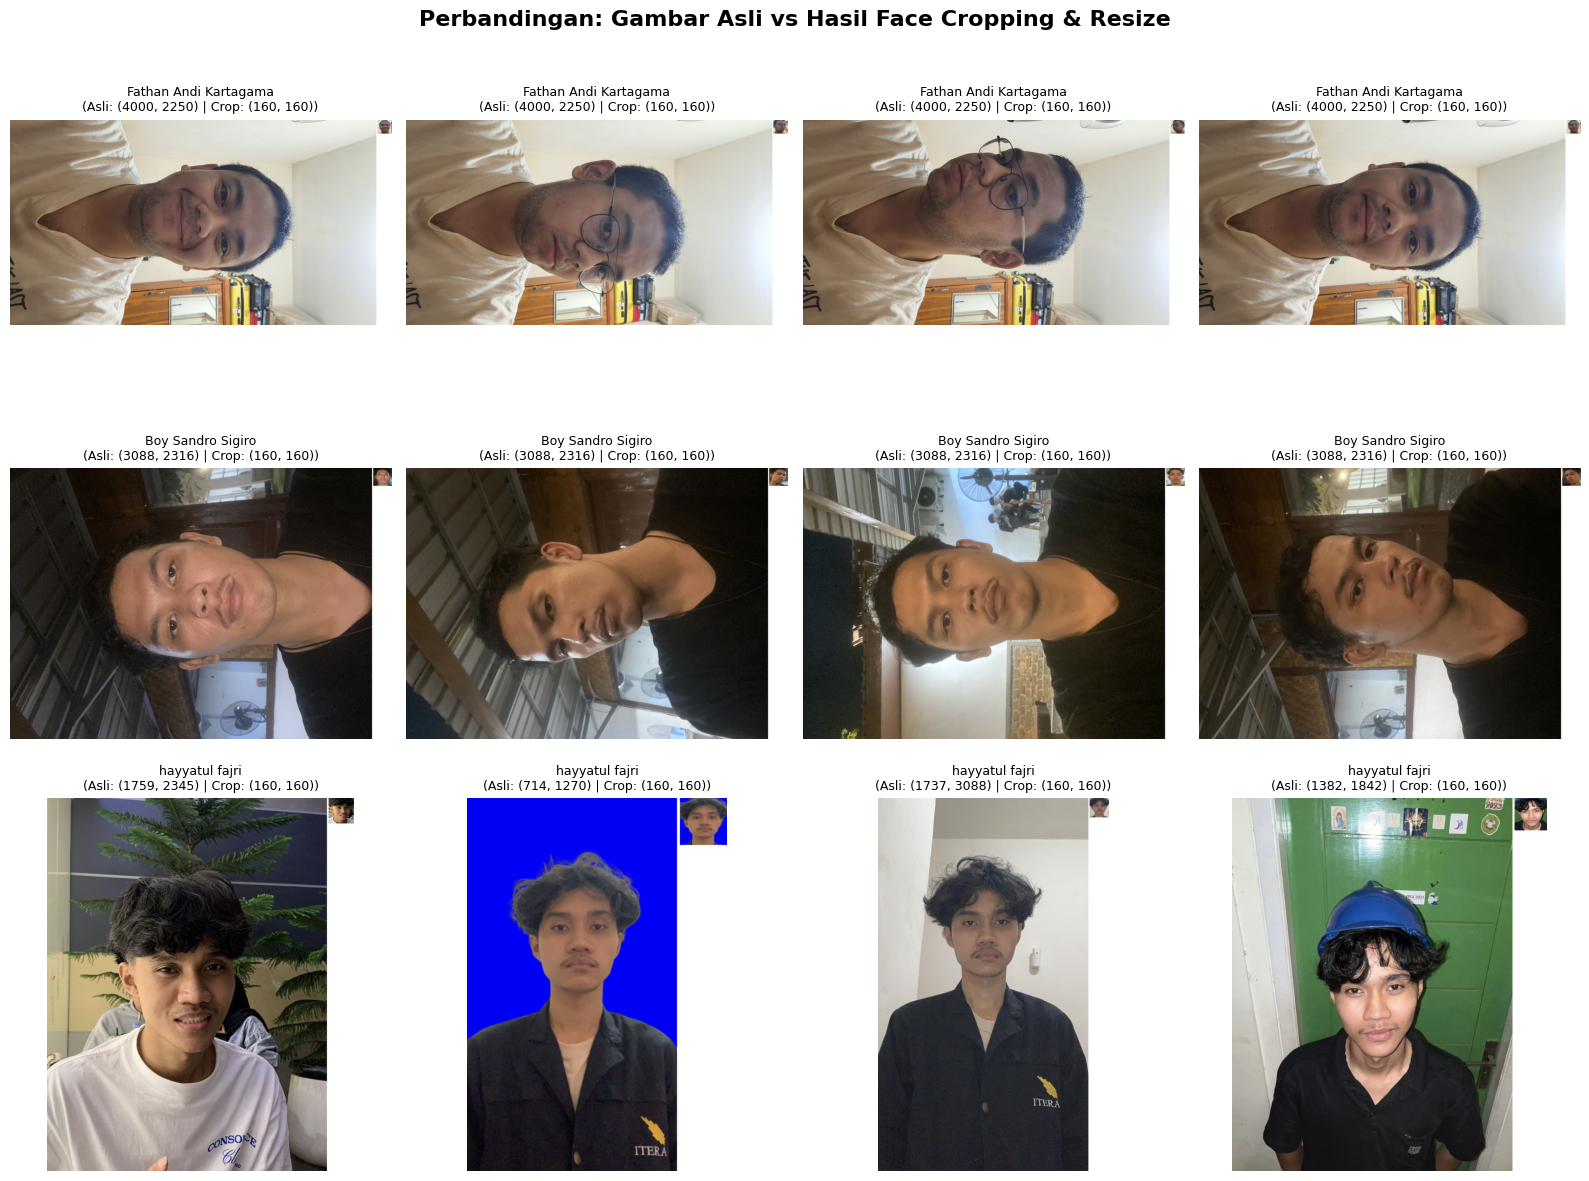


✓ Menampilkan 12 sampel hasil preprocessing
✓ Original dir: dataset/Train
✓ Cropped dir: dataset/Data_Cropped


In [5]:
# Visualisasi hasil preprocessing (face cropping)
import random

def visualize_preprocessing_results(original_dir, cropped_dir, num_samples=12):
    """Menampilkan perbandingan gambar asli vs hasil cropping"""
    
    # Ambil beberapa kelas secara random
    available_classes = [d for d in os.listdir(cropped_dir) 
                        if os.path.isdir(os.path.join(cropped_dir, d))]
    
    if len(available_classes) == 0:
        print("Tidak ada data yang ditemukan!")
        return
    
    # Pilih kelas secara random
    selected_classes = random.sample(available_classes, min(3, len(available_classes)))
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Perbandingan: Gambar Asli vs Hasil Face Cropping & Resize', 
                 fontsize=16, fontweight='bold')
    
    sample_idx = 0
    
    for class_name in selected_classes:
        original_class_path = os.path.join(original_dir, class_name)
        cropped_class_path = os.path.join(cropped_dir, class_name)
        
        # Ambil gambar yang ada di kedua folder
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
        original_images = [f for f in os.listdir(original_class_path) 
                          if f.lower().endswith(valid_extensions)]
        cropped_images = [f for f in os.listdir(cropped_class_path) 
                         if f.lower().endswith(valid_extensions)]
        
        # Cari gambar yang ada di kedua folder
        common_images = list(set(original_images) & set(cropped_images))
        
        if len(common_images) == 0:
            continue
        
        # Pilih 4 gambar random dari kelas ini
        samples_to_show = min(4, len(common_images))
        selected_images = random.sample(common_images, samples_to_show)
        
        for img_name in selected_images:
            if sample_idx >= 12:
                break
                
            row = sample_idx // 4
            col = sample_idx % 4
            
            # Load gambar asli
            orig_path = os.path.join(original_class_path, img_name)
            crop_path = os.path.join(cropped_class_path, img_name)
            
            try:
                # Gambar asli
                orig_img = Image.open(orig_path).convert('RGB')
                crop_img = Image.open(crop_path).convert('RGB')
                
                # Buat subplot dengan 2 gambar side by side
                ax = axes[row, col]
                
                # Gabungkan kedua gambar
                combined_width = orig_img.width + crop_img.width + 10
                combined_height = max(orig_img.height, crop_img.height)
                combined_img = Image.new('RGB', (combined_width, combined_height), (255, 255, 255))
                combined_img.paste(orig_img, (0, 0))
                combined_img.paste(crop_img, (orig_img.width + 10, 0))
                
                ax.imshow(combined_img)
                ax.set_title(f'{class_name}\n(Asli: {orig_img.size} | Crop: {crop_img.size})', 
                           fontsize=9)
                ax.axis('off')
                
                sample_idx += 1
                
            except Exception as e:
                print(f"Error loading {img_name}: {e}")
                continue
    
    # Sembunyikan subplot yang tidak digunakan
    for idx in range(sample_idx, 12):
        row = idx // 4
        col = idx % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Menampilkan {sample_idx} sampel hasil preprocessing")
    print(f"✓ Original dir: {original_dir}")
    print(f"✓ Cropped dir: {cropped_dir}")

# Jalankan visualisasi
visualize_preprocessing_results(SOURCE_DIR, DEST_DIR, num_samples=12)

In [6]:
def custom_stratified_split(dataset, train_ratio=0.7):
    class_indices = defaultdict(list)

    for idx, label in enumerate(dataset.targets):
        class_indices[label].append(idx)

    train_indices = []
    val_indices = []
    test_indices = []

    classes_warning = []

    print(f"Memproses {len(class_indices)} kelas...")

    for class_id, indices in class_indices.items():
        np.random.shuffle(indices)
        count = len(indices)

        if count >= 3:
            test_indices.append(indices[0])
            val_indices.append(indices[1])
            train_indices.extend(indices[2:])

        elif count == 2:
            test_indices.append(indices[1])
            train_indices.append(indices[0])
            classes_warning.append(dataset.classes[class_id])

        elif count == 1:
            train_indices.append(indices[0])
            classes_warning.append(dataset.classes[class_id])

    # Print Info Statistik
    print(f"\nHasil Split:")
    print(f"Train : {len(train_indices)}")
    print(f"Val   : {len(val_indices)}")
    print(f"Test  : {len(test_indices)}")

    if classes_warning:
        print(f"\nPERINGATAN: {len(classes_warning)} kelas hanya punya 1 gambar (Hanya masuk Train).")

    return (
        Subset(dataset, train_indices),
        Subset(dataset, val_indices),
        Subset(dataset, test_indices)
    )

In [7]:
# Path ke dataset yang sudah di-crop
path_to_dataset = "dataset/Data_Cropped"
complete_dataset = datasets.ImageFolder(path_to_dataset)
subset_train, subset_val, subset_test = custom_stratified_split(complete_dataset)


class DatasetWithTransform(torch.utils.data.Dataset):
    """Enhanced wrapper dengan dynamic augmentation untuk face recognition"""
    
    def __init__(self, data_subset, transform_pipeline=None, enable_dynamic_aug=False):
        self.data_subset = data_subset
        self.transform_pipeline = transform_pipeline
        self.enable_dynamic_aug = enable_dynamic_aug
        
        # Probability-based augmentation selection
        self.aug_strategies = ['standard', 'strong', 'light']
        self.aug_probs = [0.6, 0.2, 0.2]  # 60% standard, 20% strong, 20% light
    
    def __len__(self):
        return len(self.data_subset)
    
    def __getitem__(self, index):
        image, label = self.data_subset[index]
        
        # Terapkan transformasi jika ada
        if self.transform_pipeline is not None:
            # Dynamic augmentation selection (hanya untuk training)
            if self.enable_dynamic_aug and np.random.rand() < 0.3:
                # 30% chance untuk menggunakan augmentation yang berbeda
                strategy = np.random.choice(self.aug_strategies, p=self.aug_probs)
                if strategy == 'light':
                    # Gunakan augmentation lebih ringan
                    image = transforms.Compose([
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.ColorJitter(brightness=0.1, contrast=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
                    ])(image)
                else:
                    image = self.transform_pipeline(image)
            else:
                image = self.transform_pipeline(image)
        
        return image, label


Memproses 70 kelas...

Hasil Split:
Train : 143
Val   : 70
Test  : 70


In [8]:
# Konfigurasi ukuran dan normalisasi gambar
TARGET_SIZE = 160
NORM_MEAN = [0.5, 0.5, 0.5]
NORM_STD = [0.5, 0.5, 0.5]

# ==================== PILIH SALAH SATU VERSI AUGMENTASI ====================

# VERSI 1: MINIMAL AUGMENTATION (Paling Aman untuk Face Recognition)
# Hanya flip & sedikit crop - Fokus pada fitur wajah tetap utuh
transform_train_v1 = transforms.Compose([
    transforms.RandomResizedCrop(size=(TARGET_SIZE, TARGET_SIZE), scale=(0.8, 1.0), antialias=True),  # Crop minimal
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variasi warna ringan
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# VERSI 2: MODERATE AUGMENTATION (Balanced - RECOMMENDED)
# Augmentasi sedang dengan proteksi fitur wajah
transform_train_v2 = transforms.Compose([
    transforms.RandomResizedCrop(size=(TARGET_SIZE, TARGET_SIZE), scale=(0.7, 1.0), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10),  # Rotasi kecil
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.15), ratio=(0.5, 2.0), value=0)  # Erasing minimal
])

# VERSI 3: AGGRESSIVE AUGMENTATION (Original - Untuk Dataset Besar)
# Augmentasi agresif - Cocok jika punya data banyak
transform_train_v3 = transforms.Compose([
    transforms.RandomResizedCrop(size=(TARGET_SIZE, TARGET_SIZE), scale=(0.5, 1.0), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.2), ratio=(0.5, 2.0), value=0)
])

# PILIH VERSI YANG DIGUNAKAN (GANTI ANGKA 2 KE 1 ATAU 3 JIKA MAU COBA LAIN)
AUGMENTATION_VERSION = 2

if AUGMENTATION_VERSION == 1:
    transform_train = transform_train_v1
    print("✓ Menggunakan MINIMAL AUGMENTATION (V1)")
elif AUGMENTATION_VERSION == 2:
    transform_train = transform_train_v2
    print("✓ Menggunakan MODERATE AUGMENTATION (V2) - RECOMMENDED")
else:
    transform_train = transform_train_v3
    print("✓ Menggunakan AGGRESSIVE AUGMENTATION (V3)")

# Pipeline transformasi untuk validasi dan testing (tanpa augmentasi)
transform_eval = transforms.Compose([
    transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

print("\n" + "="*60)
print("KONFIGURASI TRANSFORMASI DATA")
print("="*60)
print("\n[1] Pipeline Training (dengan augmentasi):")
print(transform_train)

print("\n[2] Pipeline Evaluasi (tanpa augmentasi):")
print(transform_eval)
print("="*60)

✓ Menggunakan MODERATE AUGMENTATION (V2) - RECOMMENDED

KONFIGURASI TRANSFORMASI DATA

[1] Pipeline Training (dengan augmentasi):
Compose(
    RandomResizedCrop(size=(160, 160), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    RandomErasing(p=0.1, scale=(0.02, 0.15), ratio=(0.5, 2.0), value=0, inplace=False)
)

[2] Pipeline Evaluasi (tanpa augmentasi):
Compose(
    Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


✓ Dataset siap: Train=143, Val=70, Test=70

VISUALISASI HASIL AUGMENTASI DATA TRAINING


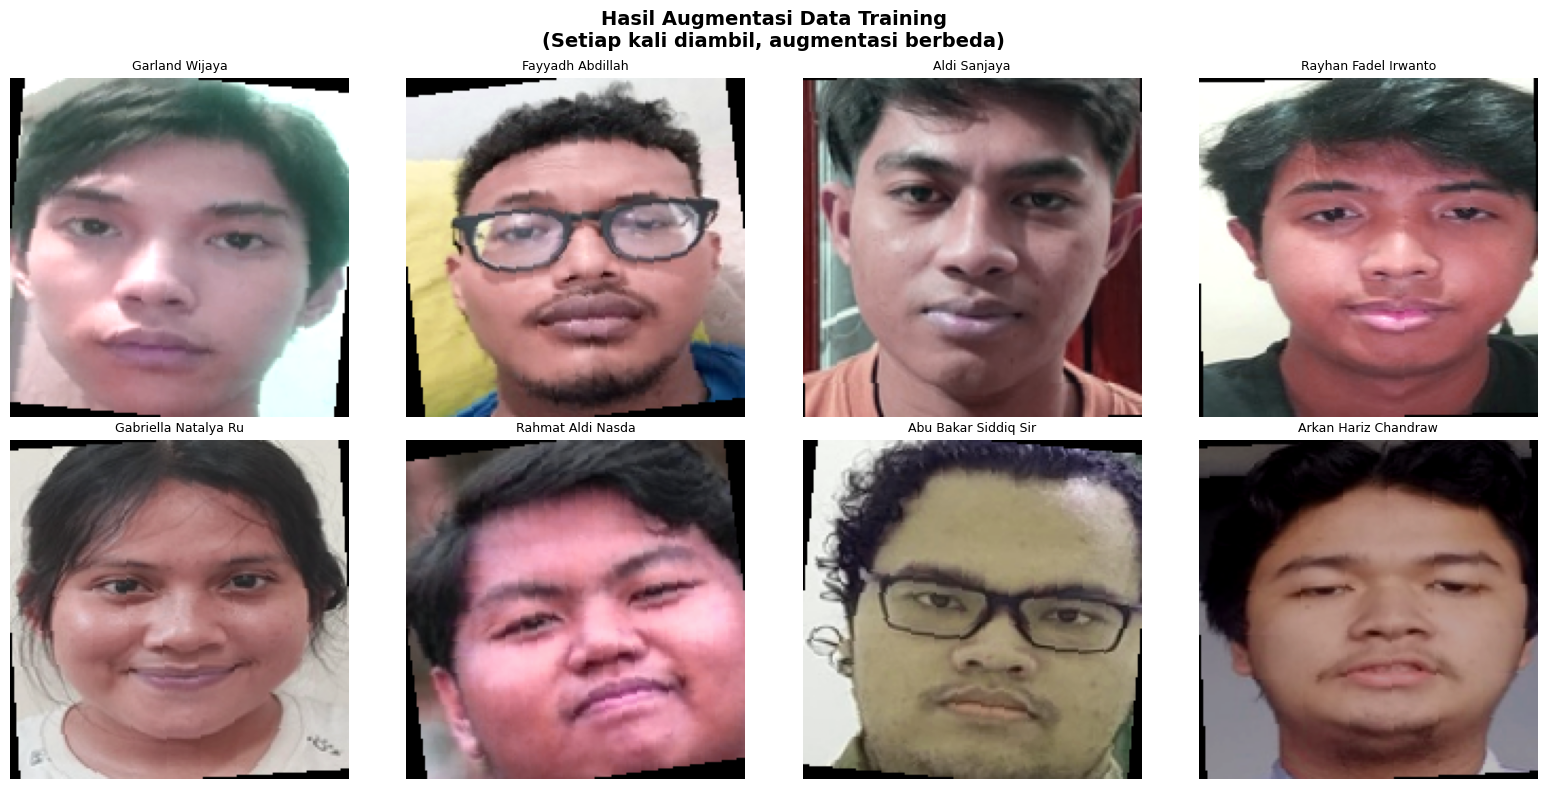


✓ Augmentasi yang digunakan (Versi 2):
  • RandomResizedCrop (zoom 70-100%) - SEDANG
  • RandomHorizontalFlip (50%)
  • ColorJitter - Sedang
  • RandomRotation (±10°)
  • RandomErasing (10%, area kecil)
  ⚡ BALANCED - Recommended untuk face recognition


In [9]:
# Buat dataset dengan transformasi yang sesuai
dataset_train = DatasetWithTransform(subset_train, transform_pipeline=transform_train)
dataset_val = DatasetWithTransform(subset_val, transform_pipeline=transform_eval)

dataset_test = DatasetWithTransform(subset_test, transform_pipeline=transform_eval)
print(f"✓ Dataset siap: Train={len(dataset_train)}, Val={len(dataset_val)}, Test={len(dataset_test)}")

# ==================== VISUALISASI HASIL AUGMENTASI ====================
print("\n" + "="*70)
print("VISUALISASI HASIL AUGMENTASI DATA TRAINING")
print("="*70)

# Fungsi untuk denormalize image agar bisa ditampilkan
def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """Denormalize tensor untuk visualisasi"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

# Ambil beberapa sample dari dataset training
num_samples = 8
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Hasil Augmentasi Data Training\n(Setiap kali diambil, augmentasi berbeda)', 
             fontsize=14, fontweight='bold')

for idx in range(num_samples):
    # Ambil gambar dari dataset (dengan augmentasi)
    random_idx = np.random.randint(0, len(dataset_train))
    augmented_img, label = dataset_train[random_idx]
    
    # Denormalize untuk visualisasi
    img_display = denormalize(augmented_img)
    
    # Konversi ke numpy dan transpose ke format (H, W, C)
    img_np = img_display.permute(1, 2, 0).numpy()
    
    # Dapatkan nama kelas
    class_name = complete_dataset.classes[label]
    
    # Plot
    row = idx // 4
    col = idx % 4
    axes[row, col].imshow(img_np)
    axes[row, col].set_title(f'{class_name[:20]}', fontsize=9)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Augmentasi yang digunakan (Versi {AUGMENTATION_VERSION}):")
if AUGMENTATION_VERSION == 1:
    print("  • RandomResizedCrop (zoom 80-100%) - MINIMAL")
    print("  • RandomHorizontalFlip (50%)")
    print("  • ColorJitter - Ringan")
    print("  • Tidak ada RandomErasing")
    print("  ⚡ PALING AMAN - Fitur wajah tetap utuh")
elif AUGMENTATION_VERSION == 2:
    print("  • RandomResizedCrop (zoom 70-100%) - SEDANG")
    print("  • RandomHorizontalFlip (50%)")
    print("  • ColorJitter - Sedang")
    print("  • RandomRotation (±10°)")
    print("  • RandomErasing (10%, area kecil)")
    print("  ⚡ BALANCED - Recommended untuk face recognition")
else:
    print("  • RandomResizedCrop (zoom 50-100%) - AGRESIF")
    print("  • RandomHorizontalFlip (50%)")
    print("  • TrivialAugmentWide (semua augmentasi)")
    print("  • RandomErasing (10%)")
    print("  ⚡ UNTUK DATASET BESAR - Bisa turunkan akurasi jika data sedikit")
print("="*70)


In [19]:
# Konfigurasi DataLoader
# ==================== HYPERPARAMETER TRAINING ====================
BATCH_SIZE = 16          # Ukuran batch untuk training
NUM_EPOCHS = 80         # Maksimum epoch training
PATIENCE = 10            # Early stopping patience# ==================================================================
WORKER_COUNT = 2

loader_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKER_COUNT
)

loader_val = DataLoader(
    dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKER_COUNT
)

loader_test = DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKER_COUNT
)

print(f"✓ DataLoader berhasil dibuat dengan batch_size={BATCH_SIZE}")

✓ DataLoader berhasil dibuat dengan batch_size=16


In [20]:
# Ekstrak nama kelas dari dataset
list_kelas = complete_dataset.classes
print("Kelas yang terdeteksi:", list_kelas)
JUMLAH_KELAS = len(list_kelas)

print(f"\n{'='*70}")
print(f"INISIALISASI MODEL INCEPTIONRESNETV1 (PRETRAINED: CASIA-WEBFACE)")
print(f"{'='*70}")

# Load pretrained model dengan weights dari CASIA-WebFace (dataset Asia)
model_inception = InceptionResnetV1(
    pretrained='casia-webface', 
    classify=True, 
    num_classes=JUMLAH_KELAS
)

# Freeze semua parameter di backbone
for parameter in model_inception.parameters():
    parameter.requires_grad = False

print(f"✓ Backbone dibekukan (frozen) - {JUMLAH_KELAS} kelas target")

# Dapatkan dimensi input untuk classifier
feature_dim = model_inception.logits.in_features

# Ganti classifier head dengan proven architecture: single hidden 512 + BatchNorm
model_inception.logits = nn.Sequential(
    nn.BatchNorm1d(feature_dim),
    nn.Dropout(p=0.6),
    nn.Linear(feature_dim, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512, JUMLAH_KELAS)
)

# Pindahkan model ke device (GPU/CPU)
model_inception = model_inception.to(device)

print("Model InceptionResnetV1 siap untuk training!\n")

# Hitung jumlah parameter
print(f"{'='*70}")
total_param_count = sum(p.numel() for p in model_inception.parameters())
trainable_param_count = sum(p.numel() for p in model_inception.parameters() if p.requires_grad)

print(f"✓ Total parameter: {total_param_count:,}")
print(f"✓ Parameter trainable: {trainable_param_count:,}")


Kelas yang terdeteksi: ['Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar', 'Ahmad Faqih Hasani', 'Aldi Sanjaya', 'Alfajar', 'Alief Fathur Rahman', 'Arkan Hariz Chandrawinata Liem', 'Bayu Ega Ferdana', 'Bayu Prameswara Haris', 'Bezalel Samuel Manik', 'Bintang Fikri Fauzan', 'Boy Sandro Sigiro', 'Desty Ananta Purba', 'Dimas Azi Rajab Aizar', 'Dito Rifki Irawan', 'Dwi Arthur Revangga', 'Dyo Dwi Carol Bukit', 'Eden Wijaya', 'Eichal Elphindo Ginting', 'Elsa Elisa Yohana Sianturi', 'Fajrul Ramadhana Aqsa', 'Falih Dzakwan Zuhdi', 'Fathan Andi Kartagama', 'Fayyadh Abdillah', 'Femmy Aprillia Putri', 'Ferdana Al Hakim', 'Festus Mikhael', 'Fiqri Aldiansyah', 'Freddy Harahap', 'Gabriella Natalya Rumapea', 'Garland Wijaya', 'Havidz Ridho Pratama', 'Ichsan Kuntadi Baskara', 'Ikhsannudin Lathief', 'Intan Permata Sari', 'JP. Rafi Radiktya Arkan. R. AZ', 'Joshia Fernandes Sectio Purba', 'Joshua Palti Sinaga', 'Joy Daniella V', 'Joyapul Hanscalvin Panjaitan', 'Kayla Chika Lathisya', 'Kenneth Austin Wij

In [21]:
print(f"\n{'='*70}")
print(f"INISIALISASI MODEL MOBILENETV2 (PRETRAINED: IMAGENET)")
print(f"{'='*70}")

# Load pretrained MobileNetV2 dari ImageNet
model_mobile = models.mobilenet_v2(pretrained=True)

# Bekukan seluruh backbone network
for param in model_mobile.parameters():
    param.requires_grad = False

print("✓ Backbone MobileNetV2 dibekukan (frozen)")

# Ambil dimensi fitur dari classifier original
mobile_feature_dim = model_mobile.classifier[1].in_features

# Bangun classifier baru
model_mobile.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(mobile_feature_dim, 512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512, JUMLAH_KELAS)
)

# Transfer ke device
model_mobile = model_mobile.to(device)

# Statistik parameter MobileNetV2
mobile_total = sum(p.numel() for p in model_mobile.parameters())

mobile_trainable = sum(p.numel() for p in model_mobile.parameters() if p.requires_grad)

print("Model MobileNetV2 siap untuk training!\n")

print(f"\n✓ Total parameter: {mobile_total:,}")
print(f"{'='*70}")
print(f"✓ Parameter trainable: {mobile_trainable:,}")


INISIALISASI MODEL MOBILENETV2 (PRETRAINED: IMAGENET)


c:\Users\asus\miniconda3\envs\RBT\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\asus\miniconda3\envs\RBT\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Backbone MobileNetV2 dibekukan (frozen)
Model MobileNetV2 siap untuk training!


✓ Total parameter: 2,915,654
✓ Parameter trainable: 691,782


In [23]:
def create_inception_model(n_classes, target_device, dropout_rates=(0.6, 0.4)):
    """Factory function dengan proven single hidden layer + BatchNorm untuk face recognition
    
    Args:
        n_classes: Jumlah kelas output
        target_device: Device untuk model (cuda/cpu)
        dropout_rates: Tuple berisi 2 dropout rates (default: 0.6, 0.4)
    """
    # Inisialisasi model dengan pretrained weights
    net = InceptionResnetV1(pretrained='casia-webface', classify=True)
    
    # Freeze backbone layers
    for p in net.parameters():
        p.requires_grad = False
    
    # Ambil dimensi fitur
    feat_dim = net.logits.in_features
    
    # Proven head: BatchNorm input → 512 hidden → output (dengan BatchNorm untuk stability)
    net.logits = nn.Sequential(
        nn.BatchNorm1d(feat_dim),
        nn.Dropout(p=dropout_rates[0]),
        nn.Linear(feat_dim, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p=dropout_rates[1]),
        nn.Linear(512, n_classes)
    )
    
    return net.to(target_device)


In [24]:
# Konfigurasi optimizer dan learning rate scheduler
trainable_params = filter(lambda p: p.requires_grad, model_inception.parameters())
opt = optim.AdamW(trainable_params, lr=1e-3, weight_decay=1e-2)

# Cosine annealing scheduler
lr_schedule = lr_scheduler.CosineAnnealingLR(opt, T_max=NUM_EPOCHS, eta_min=1e-6)

# Loss function dengan label smoothing

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
print("✓ Loss: CrossEntropyLoss (label_smoothing=0.1)")

print("✓ Scheduler: ReduceLROnPlateau")
print("✓ Optimizer: AdamW (lr=1e-3, weight_decay=1e-2)")

✓ Loss: CrossEntropyLoss (label_smoothing=0.1)
✓ Scheduler: ReduceLROnPlateau
✓ Optimizer: AdamW (lr=1e-3, weight_decay=1e-2)


In [ ]:
def execute_training(net, loader_trn, loader_vld, loss_func, opt, sched, max_epochs, early_stop_patience, dev, fold_num, fold_idx):
    """Advanced training dengan gradient accumulation dan warmup untuk face recognition"""
    # Tracking untuk best model
    best_loss_val = float('inf')
    counter_no_improve = 0
    best_weights = copy.deepcopy(net.state_dict())
    
    # Dictionary untuk menyimpan history metrics (extended)
    metrics_history = {
        'train_loss': [], 
        'val_loss': [], 
        'train_acc': [], 
        'val_acc': [],
        'grad_norms': []  # Track gradient norms
    }
    
    # Gradient accumulation config
    ACCUM_STEPS = 2
    
    # Warmup config (lebih lama untuk stability)
    WARMUP_EPOCHS = 5
    base_lr = opt.param_groups[0]['lr']

    print(f"\n>>> Memulai Training Fold {fold_idx+1} (Gradient Accum: {ACCUM_STEPS}, Warmup: {WARMUP_EPOCHS} epochs) <<<")

    for epoch in range(max_epochs):
        net.train()

        running_train_loss = 0.0
        train_correct = 0
        train_total = 0
        grad_norms = []
        
        # Warmup learning rate
        if epoch < WARMUP_EPOCHS:
            warmup_factor = (epoch + 1) / WARMUP_EPOCHS
            for param_group in opt.param_groups:
                param_group['lr'] = base_lr * warmup_factor

        # Gunakan TQDM untuk Training
        train_loop = tqdm(loader_trn, desc=f"Fold {fold_idx+1} Epoch {epoch+1} [Train]", leave=False)

        for batch_idx, (inputs, labels) in enumerate(train_loop):
            inputs, labels = inputs.to(dev), labels.to(dev)
            
            # Standard forward pass (tanpa mixup untuk stability)
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            
            # Gradient accumulation
            loss = loss / ACCUM_STEPS
            loss.backward()
            
            if (batch_idx + 1) % ACCUM_STEPS == 0:
                # Clip gradient dan track norm
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    filter(lambda p: p.requires_grad, net.parameters()), 
                    max_norm=1.0
                )
                grad_norms.append(grad_norm.item())
                
                opt.step()
                opt.zero_grad()

            running_train_loss += loss.item() * inputs.size(0) * ACCUM_STEPS
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # Update bar
            train_loop.set_postfix(loss=loss.item() * ACCUM_STEPS)

        avg_train_loss = running_train_loss / len(loader_trn.dataset)
        avg_train_acc = 100 * train_correct / train_total
        avg_grad_norm = np.mean(grad_norms) if grad_norms else 0.0

        metrics_history['train_loss'].append(avg_train_loss)
        metrics_history['train_acc'].append(avg_train_acc)
        metrics_history['grad_norms'].append(avg_grad_norm)

        # --- VALIDATION ---
        net.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in loader_vld:
                inputs, labels = inputs.to(dev), labels.to(dev)
                outputs = net(inputs)
                loss = loss_func(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = running_val_loss / len(loader_vld.dataset)
        val_acc = 100 * correct / total

        metrics_history['val_loss'].append(avg_val_loss)
        metrics_history['val_acc'].append(val_acc)

        # Step scheduler (setelah warmup)
        if epoch >= WARMUP_EPOCHS:
            sched.step()

        current_lr = opt.param_groups[0]['lr']
        print(f"   Train Loss: {avg_train_loss:.4f} Acc: {avg_train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} Acc: {val_acc:.2f}% | LR: {current_lr:.2e} | Grad: {avg_grad_norm:.3f}")

        if avg_val_loss < best_loss_val:
            best_loss_val = avg_val_loss
            best_weights = copy.deepcopy(net.state_dict())
            counter_no_improve = 0
            save_filename = f"best_model_fold_{fold_idx+1}.pth"
            torch.save(net.state_dict(), save_filename)
            print(f"   -> Model Saved to {save_filename}")
        else:
            counter_no_improve += 1

        if counter_no_improve >= early_stop_patience:
            print(f"   Early stopping di Epoch {epoch+1}")
            break

    net.load_state_dict(best_weights)
    print(f"Selesai Fold {fold_idx+1}. Best Val Loss: {best_loss_val:.4f}")

    net.eval()
    fold_preds = []
    fold_labels = []

    with torch.no_grad():
        for inputs, labels in loader_vld:
            inputs = inputs.to(dev)
            labels = labels.to(dev)
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)

            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    return metrics_history, fold_preds, fold_labels


In [26]:
K_FOLDS = 3

# ⚠️ PENTING: Gunakan subset_train (sudah exclude test set) untuk K-Fold
# Ambil labels dari subset_train untuk stratified split
train_labels = [complete_dataset.targets[i] for i in subset_train.indices]

# Inisialisasi K-Fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

global_true_labels = []
global_pred_labels = []
all_folds_history = []

print(f"\n{'='*70}")
print(f"MEMULAI {K_FOLDS}-FOLD CROSS VALIDATION - INCEPTIONRESNETV1")
print(f"{'='*70}")
print(f"Dataset untuk K-Fold: {len(subset_train)} samples (TANPA test set)")
print(f"Test set terpisah: {len(subset_test)} samples\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_labels)), train_labels)):

    # 1. Split Data - mapping ke indices asli dari complete_dataset
    actual_train_idx = [subset_train.indices[i] for i in train_idx]
    actual_val_idx = [subset_train.indices[i] for i in val_idx]
    
    train_subset = Subset(complete_dataset, actual_train_idx)
    val_subset = Subset(complete_dataset, actual_val_idx)

    # 2. Terapkan Transform (Train=Augment, Val=Bersih)
    train_fold_dataset = DatasetWithTransform(train_subset, transform_pipeline=transform_train)
    val_fold_dataset = DatasetWithTransform(val_subset, transform_pipeline=transform_eval)

    # 3. DataLoader (num_workers=0 untuk Windows)
    train_loader_fold = DataLoader(train_fold_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
    val_loader_fold = DataLoader(val_fold_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # 4. RESET MODEL & OPTIMIZER (Wajib Fresh Instance)
    model_fold = create_inception_model(n_classes=len(complete_dataset.classes), target_device=device)

    optimizer_fold = optim.AdamW(
        filter(lambda p: p.requires_grad, model_fold.parameters()),
        lr=1e-3,
        weight_decay=1e-2
    )

    scheduler_fold = lr_scheduler.CosineAnnealingLR(optimizer_fold, T_max=NUM_EPOCHS, eta_min=1e-6)
    criterion_fold = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # 5. Jalankan Training Fold Tersebut
    history, fold_preds, fold_labels = execute_training(
        model_fold,
        train_loader_fold,
        val_loader_fold,
        criterion_fold,
        optimizer_fold,
        scheduler_fold,
        NUM_EPOCHS,
        PATIENCE,
        device,
        K_FOLDS,
        fold
    )
    
    # Kumpulkan hasil fold ini ke wadah global
    all_folds_history.append(history)
    global_true_labels.extend(fold_labels)
    global_pred_labels.extend(fold_preds)
    
    print("\n Selesai.")


MEMULAI 3-FOLD CROSS VALIDATION - INCEPTIONRESNETV1
Dataset untuk K-Fold: 143 samples (TANPA test set)
Test set terpisah: 70 samples



c:\Users\asus\miniconda3\envs\RBT\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\asus\miniconda3\envs\RBT\lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start settin


>>> Memulai Training Fold 1 (Gradient Accum: 2, Warmup: 5 epochs) <<<


   Train Loss: 3.6717 Acc: 2.50% | Val Loss: 4.2826 Acc: 2.08% | LR: 2.00e-04 | Grad: 4.641
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.6948 Acc: 1.25% | Val Loss: 4.2399 Acc: 4.17% | LR: 4.00e-04 | Grad: 5.271
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.5169 Acc: 1.25% | Val Loss: 4.1642 Acc: 10.42% | LR: 6.00e-04 | Grad: 5.270
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.4664 Acc: 8.75% | Val Loss: 4.0764 Acc: 18.75% | LR: 8.00e-04 | Grad: 5.181
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.3355 Acc: 12.50% | Val Loss: 3.9594 Acc: 33.33% | LR: 1.00e-03 | Grad: 5.205
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.1408 Acc: 25.00% | Val Loss: 3.8514 Acc: 35.42% | LR: 1.00e-03 | Grad: 5.075
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.0334 Acc: 25.00% | Val Loss: 3.7380 Acc: 39.58% | LR: 9.98e-04 | Grad: 5.065
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.8472 Acc: 35.00% | Val Loss: 3.6365 Acc: 45.83% | LR: 9.97e-04 | Grad: 5.028
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.7650 Acc: 36.25% | Val Loss: 3.5312 Acc: 50.00% | LR: 9.94e-04 | Grad: 4.987
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.5485 Acc: 50.00% | Val Loss: 3.4437 Acc: 52.08% | LR: 9.90e-04 | Grad: 4.862
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.5588 Acc: 41.25% | Val Loss: 3.3602 Acc: 52.08% | LR: 9.86e-04 | Grad: 4.772
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.4482 Acc: 50.00% | Val Loss: 3.2630 Acc: 58.33% | LR: 9.81e-04 | Grad: 4.656
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.2856 Acc: 60.00% | Val Loss: 3.1793 Acc: 62.50% | LR: 9.76e-04 | Grad: 4.671
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.2876 Acc: 55.00% | Val Loss: 3.1003 Acc: 62.50% | LR: 9.69e-04 | Grad: 4.586
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.0717 Acc: 66.25% | Val Loss: 3.0088 Acc: 64.58% | LR: 9.62e-04 | Grad: 4.309
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.9981 Acc: 66.25% | Val Loss: 2.9405 Acc: 64.58% | LR: 9.54e-04 | Grad: 4.313
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.9123 Acc: 76.25% | Val Loss: 2.8465 Acc: 72.92% | LR: 9.46e-04 | Grad: 4.081
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.8732 Acc: 78.75% | Val Loss: 2.7914 Acc: 72.92% | LR: 9.36e-04 | Grad: 4.168
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.7144 Acc: 82.50% | Val Loss: 2.7234 Acc: 75.00% | LR: 9.26e-04 | Grad: 3.927
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.6695 Acc: 87.50% | Val Loss: 2.6508 Acc: 77.08% | LR: 9.16e-04 | Grad: 3.796
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.7143 Acc: 81.25% | Val Loss: 2.5912 Acc: 77.08% | LR: 9.05e-04 | Grad: 3.903
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5953 Acc: 86.25% | Val Loss: 2.5224 Acc: 83.33% | LR: 8.93e-04 | Grad: 3.716
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.4940 Acc: 95.00% | Val Loss: 2.4479 Acc: 83.33% | LR: 8.80e-04 | Grad: 3.600
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5369 Acc: 88.75% | Val Loss: 2.3782 Acc: 85.42% | LR: 8.67e-04 | Grad: 3.610
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.4908 Acc: 86.25% | Val Loss: 2.2926 Acc: 89.58% | LR: 8.54e-04 | Grad: 3.594
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.3144 Acc: 97.50% | Val Loss: 2.2235 Acc: 87.50% | LR: 8.40e-04 | Grad: 3.247
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.2756 Acc: 92.50% | Val Loss: 2.1622 Acc: 89.58% | LR: 8.25e-04 | Grad: 3.085
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.2827 Acc: 96.25% | Val Loss: 2.1091 Acc: 89.58% | LR: 8.10e-04 | Grad: 3.088
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.2676 Acc: 93.75% | Val Loss: 2.0569 Acc: 87.50% | LR: 7.94e-04 | Grad: 3.258
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.2738 Acc: 92.50% | Val Loss: 2.0109 Acc: 87.50% | LR: 7.78e-04 | Grad: 2.970
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.1548 Acc: 96.25% | Val Loss: 1.9875 Acc: 87.50% | LR: 7.61e-04 | Grad: 2.856
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.1917 Acc: 91.25% | Val Loss: 1.9419 Acc: 89.58% | LR: 7.45e-04 | Grad: 2.903
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.2285 Acc: 91.25% | Val Loss: 1.8998 Acc: 91.67% | LR: 7.27e-04 | Grad: 3.041
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.1150 Acc: 98.75% | Val Loss: 1.8535 Acc: 91.67% | LR: 7.10e-04 | Grad: 2.804
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.0877 Acc: 96.25% | Val Loss: 1.8164 Acc: 91.67% | LR: 6.92e-04 | Grad: 2.632
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.0672 Acc: 96.25% | Val Loss: 1.7911 Acc: 89.58% | LR: 6.73e-04 | Grad: 2.642
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.0106 Acc: 97.50% | Val Loss: 1.7482 Acc: 91.67% | LR: 6.55e-04 | Grad: 2.270
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.0264 Acc: 98.75% | Val Loss: 1.7298 Acc: 91.67% | LR: 6.36e-04 | Grad: 2.522
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.0170 Acc: 97.50% | Val Loss: 1.7202 Acc: 93.75% | LR: 6.17e-04 | Grad: 2.355
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9879 Acc: 97.50% | Val Loss: 1.6966 Acc: 93.75% | LR: 5.98e-04 | Grad: 2.229
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9844 Acc: 98.75% | Val Loss: 1.6662 Acc: 93.75% | LR: 5.79e-04 | Grad: 2.347
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9853 Acc: 100.00% | Val Loss: 1.6391 Acc: 93.75% | LR: 5.59e-04 | Grad: 2.308
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9251 Acc: 100.00% | Val Loss: 1.6123 Acc: 93.75% | LR: 5.40e-04 | Grad: 2.204
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9530 Acc: 100.00% | Val Loss: 1.5850 Acc: 93.75% | LR: 5.20e-04 | Grad: 2.193
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9350 Acc: 100.00% | Val Loss: 1.5764 Acc: 93.75% | LR: 5.01e-04 | Grad: 2.013
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9134 Acc: 100.00% | Val Loss: 1.5490 Acc: 93.75% | LR: 4.81e-04 | Grad: 1.940
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9553 Acc: 97.50% | Val Loss: 1.5242 Acc: 93.75% | LR: 4.61e-04 | Grad: 2.177
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9073 Acc: 98.75% | Val Loss: 1.5215 Acc: 93.75% | LR: 4.42e-04 | Grad: 2.100
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8808 Acc: 97.50% | Val Loss: 1.5047 Acc: 91.67% | LR: 4.22e-04 | Grad: 1.838
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9585 Acc: 98.75% | Val Loss: 1.5190 Acc: 91.67% | LR: 4.03e-04 | Grad: 2.095


   Train Loss: 0.8755 Acc: 97.50% | Val Loss: 1.4952 Acc: 91.67% | LR: 3.84e-04 | Grad: 1.969
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9312 Acc: 98.75% | Val Loss: 1.4908 Acc: 93.75% | LR: 3.65e-04 | Grad: 2.089
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8760 Acc: 100.00% | Val Loss: 1.4857 Acc: 93.75% | LR: 3.46e-04 | Grad: 1.720
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.9009 Acc: 97.50% | Val Loss: 1.4706 Acc: 93.75% | LR: 3.28e-04 | Grad: 1.983
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8335 Acc: 100.00% | Val Loss: 1.4590 Acc: 93.75% | LR: 3.09e-04 | Grad: 1.644
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8306 Acc: 100.00% | Val Loss: 1.4586 Acc: 93.75% | LR: 2.91e-04 | Grad: 1.518
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8674 Acc: 98.75% | Val Loss: 1.4449 Acc: 93.75% | LR: 2.74e-04 | Grad: 1.791
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8638 Acc: 100.00% | Val Loss: 1.4392 Acc: 93.75% | LR: 2.56e-04 | Grad: 1.772
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8400 Acc: 98.75% | Val Loss: 1.4340 Acc: 93.75% | LR: 2.40e-04 | Grad: 1.702
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8575 Acc: 100.00% | Val Loss: 1.4285 Acc: 95.83% | LR: 2.23e-04 | Grad: 1.673
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8551 Acc: 98.75% | Val Loss: 1.4365 Acc: 95.83% | LR: 2.07e-04 | Grad: 1.716


   Train Loss: 0.9391 Acc: 96.25% | Val Loss: 1.4099 Acc: 95.83% | LR: 1.91e-04 | Grad: 2.099
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8514 Acc: 100.00% | Val Loss: 1.4156 Acc: 95.83% | LR: 1.76e-04 | Grad: 1.769


   Train Loss: 0.8093 Acc: 98.75% | Val Loss: 1.4148 Acc: 95.83% | LR: 1.61e-04 | Grad: 1.250


   Train Loss: 0.9038 Acc: 97.50% | Val Loss: 1.4120 Acc: 95.83% | LR: 1.47e-04 | Grad: 1.945


   Train Loss: 0.8349 Acc: 100.00% | Val Loss: 1.4089 Acc: 95.83% | LR: 1.34e-04 | Grad: 1.766
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8270 Acc: 98.75% | Val Loss: 1.4045 Acc: 93.75% | LR: 1.21e-04 | Grad: 1.651
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8515 Acc: 98.75% | Val Loss: 1.4025 Acc: 93.75% | LR: 1.08e-04 | Grad: 1.815
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8146 Acc: 100.00% | Val Loss: 1.4099 Acc: 93.75% | LR: 9.64e-05 | Grad: 1.392


   Train Loss: 0.8269 Acc: 100.00% | Val Loss: 1.4023 Acc: 95.83% | LR: 8.52e-05 | Grad: 1.588
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8448 Acc: 98.75% | Val Loss: 1.3941 Acc: 95.83% | LR: 7.46e-05 | Grad: 1.706
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8571 Acc: 98.75% | Val Loss: 1.4049 Acc: 93.75% | LR: 6.47e-05 | Grad: 1.618


   Train Loss: 0.8453 Acc: 100.00% | Val Loss: 1.4040 Acc: 93.75% | LR: 5.54e-05 | Grad: 1.552


   Train Loss: 0.8349 Acc: 98.75% | Val Loss: 1.4095 Acc: 93.75% | LR: 4.69e-05 | Grad: 1.577


   Train Loss: 0.8280 Acc: 98.75% | Val Loss: 1.3891 Acc: 95.83% | LR: 3.90e-05 | Grad: 1.672
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8328 Acc: 98.75% | Val Loss: 1.3889 Acc: 93.75% | LR: 3.19e-05 | Grad: 1.384
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8283 Acc: 98.75% | Val Loss: 1.3721 Acc: 95.83% | LR: 2.54e-05 | Grad: 1.622
   -> Model Saved to best_model_fold_1.pth
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 0.8011 Acc: 100.00% | Val Loss: 1.3750 Acc: 95.83% | LR: 1.98e-05 | Grad: 1.499


   Train Loss: 0.8112 Acc: 100.00% | Val Loss: 1.3920 Acc: 95.83% | LR: 1.48e-05 | Grad: 1.311


   Train Loss: 0.8637 Acc: 98.75% | Val Loss: 1.3914 Acc: 95.83% | LR: 1.06e-05 | Grad: 1.903
Selesai Fold 1. Best Val Loss: 1.3721

 Selesai.

>>> Memulai Training Fold 2 (Gradient Accum: 2, Warmup: 5 epochs) <<<

>>> Memulai Training Fold 2 (Gradient Accum: 2, Warmup: 5 epochs) <<<


   Train Loss: 3.6517 Acc: 2.50% | Val Loss: 4.2549 Acc: 4.17% | LR: 2.00e-04 | Grad: 4.674
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 3.6184 Acc: 6.25% | Val Loss: 4.2267 Acc: 4.17% | LR: 4.00e-04 | Grad: 5.252
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 3.5806 Acc: 1.25% | Val Loss: 4.1750 Acc: 4.17% | LR: 6.00e-04 | Grad: 5.245
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 3.5036 Acc: 5.00% | Val Loss: 4.0974 Acc: 10.42% | LR: 8.00e-04 | Grad: 5.228
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 3.3706 Acc: 10.00% | Val Loss: 3.9940 Acc: 12.50% | LR: 1.00e-03 | Grad: 5.137
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 3.1502 Acc: 20.00% | Val Loss: 3.8948 Acc: 22.92% | LR: 1.00e-03 | Grad: 5.073
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.9876 Acc: 26.25% | Val Loss: 3.8064 Acc: 25.00% | LR: 9.98e-04 | Grad: 5.156
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.8788 Acc: 37.50% | Val Loss: 3.7159 Acc: 29.17% | LR: 9.97e-04 | Grad: 4.961
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.8139 Acc: 31.25% | Val Loss: 3.6371 Acc: 35.42% | LR: 9.94e-04 | Grad: 4.927
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.5712 Acc: 41.25% | Val Loss: 3.5590 Acc: 43.75% | LR: 9.90e-04 | Grad: 4.811
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.5485 Acc: 47.50% | Val Loss: 3.4838 Acc: 43.75% | LR: 9.86e-04 | Grad: 4.830
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.4008 Acc: 56.25% | Val Loss: 3.3884 Acc: 47.92% | LR: 9.81e-04 | Grad: 4.693
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.2845 Acc: 53.75% | Val Loss: 3.3103 Acc: 50.00% | LR: 9.76e-04 | Grad: 4.504
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.1788 Acc: 57.50% | Val Loss: 3.2403 Acc: 47.92% | LR: 9.69e-04 | Grad: 4.480
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.0580 Acc: 67.50% | Val Loss: 3.1698 Acc: 50.00% | LR: 9.62e-04 | Grad: 4.281
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 2.1489 Acc: 57.50% | Val Loss: 3.0874 Acc: 52.08% | LR: 9.54e-04 | Grad: 4.301
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.9893 Acc: 66.25% | Val Loss: 3.0010 Acc: 62.50% | LR: 9.46e-04 | Grad: 4.086
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.8513 Acc: 76.25% | Val Loss: 2.9233 Acc: 66.67% | LR: 9.36e-04 | Grad: 4.136
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.7211 Acc: 76.25% | Val Loss: 2.8508 Acc: 70.83% | LR: 9.26e-04 | Grad: 3.891
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.7545 Acc: 80.00% | Val Loss: 2.7770 Acc: 72.92% | LR: 9.16e-04 | Grad: 4.038
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.6838 Acc: 86.25% | Val Loss: 2.7062 Acc: 77.08% | LR: 9.05e-04 | Grad: 3.694
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.5452 Acc: 86.25% | Val Loss: 2.6400 Acc: 77.08% | LR: 8.93e-04 | Grad: 3.657
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.6311 Acc: 86.25% | Val Loss: 2.5661 Acc: 77.08% | LR: 8.80e-04 | Grad: 3.647
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.4642 Acc: 91.25% | Val Loss: 2.4968 Acc: 77.08% | LR: 8.67e-04 | Grad: 3.350
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.5167 Acc: 86.25% | Val Loss: 2.4378 Acc: 77.08% | LR: 8.54e-04 | Grad: 3.516
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.3292 Acc: 97.50% | Val Loss: 2.3754 Acc: 79.17% | LR: 8.40e-04 | Grad: 3.227
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.3221 Acc: 96.25% | Val Loss: 2.3298 Acc: 79.17% | LR: 8.25e-04 | Grad: 3.217
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.2734 Acc: 95.00% | Val Loss: 2.2759 Acc: 79.17% | LR: 8.10e-04 | Grad: 3.129
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.2423 Acc: 96.25% | Val Loss: 2.2327 Acc: 81.25% | LR: 7.94e-04 | Grad: 3.075
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.2167 Acc: 95.00% | Val Loss: 2.1860 Acc: 81.25% | LR: 7.78e-04 | Grad: 2.807
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.1490 Acc: 98.75% | Val Loss: 2.1309 Acc: 83.33% | LR: 7.61e-04 | Grad: 2.889
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.1570 Acc: 98.75% | Val Loss: 2.0814 Acc: 83.33% | LR: 7.45e-04 | Grad: 2.683
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.1358 Acc: 96.25% | Val Loss: 2.0244 Acc: 85.42% | LR: 7.27e-04 | Grad: 2.875
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.1156 Acc: 97.50% | Val Loss: 1.9936 Acc: 87.50% | LR: 7.10e-04 | Grad: 2.619
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.0387 Acc: 100.00% | Val Loss: 1.9463 Acc: 87.50% | LR: 6.92e-04 | Grad: 2.541
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.0684 Acc: 97.50% | Val Loss: 1.9129 Acc: 87.50% | LR: 6.73e-04 | Grad: 2.632
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.0824 Acc: 97.50% | Val Loss: 1.8774 Acc: 87.50% | LR: 6.55e-04 | Grad: 2.559
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.0000 Acc: 98.75% | Val Loss: 1.8440 Acc: 87.50% | LR: 6.36e-04 | Grad: 2.205
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 1.0022 Acc: 97.50% | Val Loss: 1.8147 Acc: 87.50% | LR: 6.17e-04 | Grad: 2.437
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9107 Acc: 100.00% | Val Loss: 1.7763 Acc: 87.50% | LR: 5.98e-04 | Grad: 2.100
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9516 Acc: 96.25% | Val Loss: 1.7512 Acc: 87.50% | LR: 5.79e-04 | Grad: 1.902
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9793 Acc: 98.75% | Val Loss: 1.7222 Acc: 87.50% | LR: 5.59e-04 | Grad: 2.292
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9473 Acc: 98.75% | Val Loss: 1.7128 Acc: 87.50% | LR: 5.40e-04 | Grad: 2.183
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9736 Acc: 97.50% | Val Loss: 1.7015 Acc: 87.50% | LR: 5.20e-04 | Grad: 2.311
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9645 Acc: 95.00% | Val Loss: 1.6752 Acc: 87.50% | LR: 5.01e-04 | Grad: 2.053
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9462 Acc: 98.75% | Val Loss: 1.6637 Acc: 87.50% | LR: 4.81e-04 | Grad: 2.270
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9210 Acc: 100.00% | Val Loss: 1.6483 Acc: 87.50% | LR: 4.61e-04 | Grad: 2.087
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8621 Acc: 98.75% | Val Loss: 1.6303 Acc: 87.50% | LR: 4.42e-04 | Grad: 1.618
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8859 Acc: 97.50% | Val Loss: 1.6312 Acc: 87.50% | LR: 4.22e-04 | Grad: 1.960


   Train Loss: 0.8999 Acc: 100.00% | Val Loss: 1.6276 Acc: 87.50% | LR: 4.03e-04 | Grad: 1.948
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8674 Acc: 100.00% | Val Loss: 1.6126 Acc: 87.50% | LR: 3.84e-04 | Grad: 1.920
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9394 Acc: 96.25% | Val Loss: 1.6085 Acc: 87.50% | LR: 3.65e-04 | Grad: 2.056
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8478 Acc: 100.00% | Val Loss: 1.5932 Acc: 87.50% | LR: 3.46e-04 | Grad: 1.737
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9037 Acc: 100.00% | Val Loss: 1.5785 Acc: 87.50% | LR: 3.28e-04 | Grad: 1.745
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.9108 Acc: 98.75% | Val Loss: 1.5758 Acc: 87.50% | LR: 3.09e-04 | Grad: 2.070
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8772 Acc: 98.75% | Val Loss: 1.5733 Acc: 87.50% | LR: 2.91e-04 | Grad: 1.875
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8507 Acc: 100.00% | Val Loss: 1.5709 Acc: 87.50% | LR: 2.74e-04 | Grad: 1.660
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8369 Acc: 100.00% | Val Loss: 1.5393 Acc: 87.50% | LR: 2.56e-04 | Grad: 1.726
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8304 Acc: 100.00% | Val Loss: 1.5334 Acc: 87.50% | LR: 2.40e-04 | Grad: 1.689
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8513 Acc: 98.75% | Val Loss: 1.5257 Acc: 87.50% | LR: 2.23e-04 | Grad: 1.623
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8050 Acc: 100.00% | Val Loss: 1.5329 Acc: 87.50% | LR: 2.07e-04 | Grad: 1.497


   Train Loss: 0.9420 Acc: 96.25% | Val Loss: 1.5330 Acc: 87.50% | LR: 1.91e-04 | Grad: 2.034


   Train Loss: 0.8457 Acc: 100.00% | Val Loss: 1.5118 Acc: 87.50% | LR: 1.76e-04 | Grad: 1.595
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8252 Acc: 98.75% | Val Loss: 1.5112 Acc: 87.50% | LR: 1.61e-04 | Grad: 1.664
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8682 Acc: 98.75% | Val Loss: 1.5103 Acc: 87.50% | LR: 1.47e-04 | Grad: 1.732
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8537 Acc: 97.50% | Val Loss: 1.4925 Acc: 87.50% | LR: 1.34e-04 | Grad: 1.785
   -> Model Saved to best_model_fold_2.pth
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 0.8503 Acc: 100.00% | Val Loss: 1.4988 Acc: 87.50% | LR: 1.21e-04 | Grad: 1.600


   Train Loss: 0.8397 Acc: 100.00% | Val Loss: 1.5106 Acc: 87.50% | LR: 1.08e-04 | Grad: 1.663


   Train Loss: 0.7970 Acc: 100.00% | Val Loss: 1.5061 Acc: 87.50% | LR: 9.64e-05 | Grad: 1.298


   Train Loss: 0.8142 Acc: 98.75% | Val Loss: 1.5108 Acc: 87.50% | LR: 8.52e-05 | Grad: 1.548


   Train Loss: 0.8281 Acc: 97.50% | Val Loss: 1.4977 Acc: 87.50% | LR: 7.46e-05 | Grad: 1.563


   Train Loss: 0.7926 Acc: 100.00% | Val Loss: 1.4982 Acc: 87.50% | LR: 6.47e-05 | Grad: 1.366


   Train Loss: 0.8428 Acc: 100.00% | Val Loss: 1.5136 Acc: 87.50% | LR: 5.54e-05 | Grad: 1.631


   Train Loss: 0.8293 Acc: 98.75% | Val Loss: 1.5126 Acc: 87.50% | LR: 4.69e-05 | Grad: 1.441


   Train Loss: 0.8080 Acc: 100.00% | Val Loss: 1.5131 Acc: 87.50% | LR: 3.90e-05 | Grad: 1.562


   Train Loss: 0.7899 Acc: 100.00% | Val Loss: 1.5207 Acc: 87.50% | LR: 3.19e-05 | Grad: 1.352
   Early stopping di Epoch 76
Selesai Fold 2. Best Val Loss: 1.4925

 Selesai.

>>> Memulai Training Fold 3 (Gradient Accum: 2, Warmup: 5 epochs) <<<

>>> Memulai Training Fold 3 (Gradient Accum: 2, Warmup: 5 epochs) <<<


   Train Loss: 4.4481 Acc: 0.00% | Val Loss: 4.1800 Acc: 2.13% | LR: 2.00e-04 | Grad: 4.740
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 4.3650 Acc: 1.04% | Val Loss: 4.1225 Acc: 10.64% | LR: 4.00e-04 | Grad: 4.754
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 4.1516 Acc: 7.29% | Val Loss: 4.0456 Acc: 19.15% | LR: 6.00e-04 | Grad: 4.723
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 4.0297 Acc: 7.29% | Val Loss: 3.9489 Acc: 21.28% | LR: 8.00e-04 | Grad: 4.647
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.7237 Acc: 17.71% | Val Loss: 3.8294 Acc: 21.28% | LR: 1.00e-03 | Grad: 4.603
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.4206 Acc: 33.33% | Val Loss: 3.7243 Acc: 29.79% | LR: 1.00e-03 | Grad: 4.503
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.2593 Acc: 39.58% | Val Loss: 3.6083 Acc: 31.91% | LR: 9.98e-04 | Grad: 4.334
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.0267 Acc: 48.96% | Val Loss: 3.4945 Acc: 38.30% | LR: 9.97e-04 | Grad: 4.321
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.8684 Acc: 52.08% | Val Loss: 3.3804 Acc: 44.68% | LR: 9.94e-04 | Grad: 4.210
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.6816 Acc: 57.29% | Val Loss: 3.2737 Acc: 48.94% | LR: 9.90e-04 | Grad: 4.139
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.5830 Acc: 59.38% | Val Loss: 3.1697 Acc: 51.06% | LR: 9.86e-04 | Grad: 3.930
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.3116 Acc: 73.96% | Val Loss: 3.0588 Acc: 55.32% | LR: 9.81e-04 | Grad: 3.743
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.2421 Acc: 73.96% | Val Loss: 2.9621 Acc: 61.70% | LR: 9.76e-04 | Grad: 3.670
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.0406 Acc: 83.33% | Val Loss: 2.8595 Acc: 63.83% | LR: 9.69e-04 | Grad: 3.513
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.9407 Acc: 85.42% | Val Loss: 2.7679 Acc: 65.96% | LR: 9.62e-04 | Grad: 3.365
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.8322 Acc: 88.54% | Val Loss: 2.6760 Acc: 68.09% | LR: 9.54e-04 | Grad: 3.210
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.7217 Acc: 92.71% | Val Loss: 2.5732 Acc: 70.21% | LR: 9.46e-04 | Grad: 3.125
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.6335 Acc: 95.83% | Val Loss: 2.4877 Acc: 70.21% | LR: 9.36e-04 | Grad: 2.984
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.5439 Acc: 93.75% | Val Loss: 2.3975 Acc: 72.34% | LR: 9.26e-04 | Grad: 2.833
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.4723 Acc: 95.83% | Val Loss: 2.3240 Acc: 78.72% | LR: 9.16e-04 | Grad: 2.704
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.3712 Acc: 96.88% | Val Loss: 2.2435 Acc: 80.85% | LR: 9.05e-04 | Grad: 2.491
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.3353 Acc: 100.00% | Val Loss: 2.1633 Acc: 78.72% | LR: 8.93e-04 | Grad: 2.516
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.3718 Acc: 95.83% | Val Loss: 2.1073 Acc: 80.85% | LR: 8.80e-04 | Grad: 2.540
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.2600 Acc: 98.96% | Val Loss: 2.0568 Acc: 82.98% | LR: 8.67e-04 | Grad: 2.375
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.2023 Acc: 96.88% | Val Loss: 1.9945 Acc: 85.11% | LR: 8.54e-04 | Grad: 2.161
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.1556 Acc: 97.92% | Val Loss: 1.9354 Acc: 87.23% | LR: 8.40e-04 | Grad: 2.018
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.1225 Acc: 98.96% | Val Loss: 1.8736 Acc: 89.36% | LR: 8.25e-04 | Grad: 1.910
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.1599 Acc: 95.83% | Val Loss: 1.8338 Acc: 85.11% | LR: 8.10e-04 | Grad: 1.956
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.0770 Acc: 100.00% | Val Loss: 1.8074 Acc: 87.23% | LR: 7.94e-04 | Grad: 1.758
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.0784 Acc: 96.88% | Val Loss: 1.7710 Acc: 87.23% | LR: 7.78e-04 | Grad: 1.802
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.0855 Acc: 96.88% | Val Loss: 1.7414 Acc: 89.36% | LR: 7.61e-04 | Grad: 1.831
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.1101 Acc: 97.92% | Val Loss: 1.7278 Acc: 89.36% | LR: 7.45e-04 | Grad: 1.897
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.0120 Acc: 100.00% | Val Loss: 1.6983 Acc: 89.36% | LR: 7.27e-04 | Grad: 1.543
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9855 Acc: 100.00% | Val Loss: 1.6746 Acc: 89.36% | LR: 7.10e-04 | Grad: 1.445
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9804 Acc: 100.00% | Val Loss: 1.6512 Acc: 89.36% | LR: 6.92e-04 | Grad: 1.367
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.0349 Acc: 96.88% | Val Loss: 1.6235 Acc: 89.36% | LR: 6.73e-04 | Grad: 1.654
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9799 Acc: 98.96% | Val Loss: 1.6145 Acc: 89.36% | LR: 6.55e-04 | Grad: 1.395
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9713 Acc: 98.96% | Val Loss: 1.6001 Acc: 89.36% | LR: 6.36e-04 | Grad: 1.306
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.0000 Acc: 100.00% | Val Loss: 1.5831 Acc: 89.36% | LR: 6.17e-04 | Grad: 1.476
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9838 Acc: 100.00% | Val Loss: 1.5617 Acc: 89.36% | LR: 5.98e-04 | Grad: 1.387
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9513 Acc: 100.00% | Val Loss: 1.5592 Acc: 89.36% | LR: 5.79e-04 | Grad: 1.158
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9908 Acc: 100.00% | Val Loss: 1.5547 Acc: 89.36% | LR: 5.59e-04 | Grad: 1.468
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9441 Acc: 98.96% | Val Loss: 1.5499 Acc: 89.36% | LR: 5.40e-04 | Grad: 1.176
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.0073 Acc: 97.92% | Val Loss: 1.5419 Acc: 91.49% | LR: 5.20e-04 | Grad: 1.489
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9385 Acc: 100.00% | Val Loss: 1.5450 Acc: 91.49% | LR: 5.01e-04 | Grad: 1.112


   Train Loss: 0.9476 Acc: 100.00% | Val Loss: 1.5480 Acc: 91.49% | LR: 4.81e-04 | Grad: 1.210


   Train Loss: 0.9193 Acc: 100.00% | Val Loss: 1.5453 Acc: 91.49% | LR: 4.61e-04 | Grad: 1.003


   Train Loss: 0.9142 Acc: 98.96% | Val Loss: 1.5431 Acc: 91.49% | LR: 4.42e-04 | Grad: 1.050


   Train Loss: 0.9479 Acc: 98.96% | Val Loss: 1.5461 Acc: 91.49% | LR: 4.22e-04 | Grad: 1.100


   Train Loss: 0.9500 Acc: 100.00% | Val Loss: 1.5286 Acc: 91.49% | LR: 4.03e-04 | Grad: 1.192
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9824 Acc: 100.00% | Val Loss: 1.5157 Acc: 87.23% | LR: 3.84e-04 | Grad: 1.366
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9703 Acc: 98.96% | Val Loss: 1.5123 Acc: 91.49% | LR: 3.65e-04 | Grad: 1.357
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9488 Acc: 98.96% | Val Loss: 1.5061 Acc: 87.23% | LR: 3.46e-04 | Grad: 1.223
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9749 Acc: 98.96% | Val Loss: 1.5076 Acc: 89.36% | LR: 3.28e-04 | Grad: 1.344


   Train Loss: 0.9094 Acc: 100.00% | Val Loss: 1.5007 Acc: 91.49% | LR: 3.09e-04 | Grad: 0.932
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9859 Acc: 97.92% | Val Loss: 1.4972 Acc: 89.36% | LR: 2.91e-04 | Grad: 1.332
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9160 Acc: 100.00% | Val Loss: 1.4905 Acc: 89.36% | LR: 2.74e-04 | Grad: 0.902
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9207 Acc: 100.00% | Val Loss: 1.4967 Acc: 85.11% | LR: 2.56e-04 | Grad: 0.982


   Train Loss: 0.9642 Acc: 97.92% | Val Loss: 1.4882 Acc: 87.23% | LR: 2.40e-04 | Grad: 1.224
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9257 Acc: 100.00% | Val Loss: 1.4926 Acc: 89.36% | LR: 2.23e-04 | Grad: 1.050


   Train Loss: 0.9445 Acc: 100.00% | Val Loss: 1.4973 Acc: 89.36% | LR: 2.07e-04 | Grad: 1.105


   Train Loss: 0.9188 Acc: 100.00% | Val Loss: 1.4978 Acc: 89.36% | LR: 1.91e-04 | Grad: 0.941


   Train Loss: 0.9935 Acc: 95.83% | Val Loss: 1.4972 Acc: 91.49% | LR: 1.76e-04 | Grad: 1.408


   Train Loss: 0.9095 Acc: 100.00% | Val Loss: 1.4873 Acc: 85.11% | LR: 1.61e-04 | Grad: 0.955
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9152 Acc: 100.00% | Val Loss: 1.4958 Acc: 89.36% | LR: 1.47e-04 | Grad: 0.923


   Train Loss: 0.9681 Acc: 95.83% | Val Loss: 1.4892 Acc: 89.36% | LR: 1.34e-04 | Grad: 1.402


   Train Loss: 0.9449 Acc: 98.96% | Val Loss: 1.4898 Acc: 89.36% | LR: 1.21e-04 | Grad: 1.137


   Train Loss: 0.9271 Acc: 100.00% | Val Loss: 1.4918 Acc: 89.36% | LR: 1.08e-04 | Grad: 1.054


   Train Loss: 0.9459 Acc: 98.96% | Val Loss: 1.4931 Acc: 89.36% | LR: 9.64e-05 | Grad: 1.061


   Train Loss: 0.9242 Acc: 100.00% | Val Loss: 1.4876 Acc: 89.36% | LR: 8.52e-05 | Grad: 1.039


   Train Loss: 0.9273 Acc: 100.00% | Val Loss: 1.4820 Acc: 89.36% | LR: 7.46e-05 | Grad: 1.099
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9332 Acc: 98.96% | Val Loss: 1.4855 Acc: 89.36% | LR: 6.47e-05 | Grad: 1.037


   Train Loss: 0.9347 Acc: 96.88% | Val Loss: 1.4796 Acc: 89.36% | LR: 5.54e-05 | Grad: 1.034
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9383 Acc: 100.00% | Val Loss: 1.4808 Acc: 89.36% | LR: 4.69e-05 | Grad: 1.040


   Train Loss: 0.9000 Acc: 100.00% | Val Loss: 1.4795 Acc: 89.36% | LR: 3.90e-05 | Grad: 0.849
   -> Model Saved to best_model_fold_3.pth
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 0.9839 Acc: 96.88% | Val Loss: 1.4843 Acc: 87.23% | LR: 3.19e-05 | Grad: 1.286


   Train Loss: 0.9298 Acc: 100.00% | Val Loss: 1.4848 Acc: 89.36% | LR: 2.54e-05 | Grad: 0.977


   Train Loss: 0.9488 Acc: 100.00% | Val Loss: 1.4862 Acc: 89.36% | LR: 1.98e-05 | Grad: 1.181


   Train Loss: 0.9374 Acc: 98.96% | Val Loss: 1.4930 Acc: 89.36% | LR: 1.48e-05 | Grad: 1.080


   Train Loss: 0.9784 Acc: 98.96% | Val Loss: 1.4888 Acc: 89.36% | LR: 1.06e-05 | Grad: 1.271
Selesai Fold 3. Best Val Loss: 1.4795

 Selesai.

 Selesai.


In [28]:
# ==================== SIMPAN MODEL TERBAIK ====================
print("\n" + "="*70)
print("MENYIMPAN MODEL TERBAIK DARI CROSS VALIDATION")
print("="*70)

# Cari fold dengan validation loss terkecil
best_fold_idx = 0
best_val_loss = float('inf')

for i, history in enumerate(all_folds_history):
    final_train_loss = history['train_loss'][-1]
    final_train_acc = history['train_acc'][-1]
    final_val_loss = history['val_loss'][-1]
    final_val_acc = history['val_acc'][-1]
    print(f"Fold {i+1} - Train Loss: {final_train_loss:.4f} | Train Acc: {final_train_acc:.2f}% | Val Loss: {final_val_loss:.4f} | Val Acc: {final_val_acc:.2f}%")
    
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_fold_idx = i

# Ambil akurasi terbaik
best_train_loss = all_folds_history[best_fold_idx]['train_loss'][-1]
best_train_acc = all_folds_history[best_fold_idx]['train_acc'][-1]
best_val_acc = all_folds_history[best_fold_idx]['val_acc'][-1]

print(f"\n{'='*70}")
print(f"🏆 MODEL TERBAIK: Fold {best_fold_idx+1}")
print(f"   Training Loss      : {best_train_loss:.4f}")
print(f"   Training Accuracy  : {best_train_acc:.2f}%")
print(f"   Validation Loss    : {best_val_loss:.4f}")
print(f"   Validation Accuracy: {best_val_acc:.2f}%")
print(f"{'='*70}")

# Path model terbaik yang sudah disimpan saat training
best_model_source = f"best_model_fold_{best_fold_idx+1}.pth"

# Copy ke final best model
final_best_model_path = "final_best_model.pth"
import shutil
shutil.copy(best_model_source, final_best_model_path)

print(f"\n✓ Model terbaik disimpan ke: {final_best_model_path}")
print(f"✓ Source: {best_model_source}")

# Simpan juga informasi model
model_info = {
    'best_fold': best_fold_idx + 1,
    'best_train_loss': float(best_train_loss),
    'best_train_accuracy': float(best_train_acc),
    'best_val_loss': float(best_val_loss),
    'best_val_accuracy': float(best_val_acc),
    'num_classes': len(complete_dataset.classes),
    'class_names': complete_dataset.classes,
    'image_size': TARGET_SIZE,
    'model_architecture': 'InceptionResnetV1',
    'pretrained_on': 'casia-webface'
}

import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"✓ Informasi model disimpan ke: model_info.json")
print(f"{'='*70}")


MENYIMPAN MODEL TERBAIK DARI CROSS VALIDATION
Fold 1 - Train Loss: 0.8637 | Train Acc: 98.75% | Val Loss: 1.3914 | Val Acc: 95.83%
Fold 2 - Train Loss: 0.7899 | Train Acc: 100.00% | Val Loss: 1.5207 | Val Acc: 87.50%
Fold 3 - Train Loss: 0.9784 | Train Acc: 98.96% | Val Loss: 1.4888 | Val Acc: 89.36%

🏆 MODEL TERBAIK: Fold 1
   Training Loss      : 0.8637
   Training Accuracy  : 98.75%
   Validation Loss    : 1.3914
   Validation Accuracy: 95.83%

✓ Model terbaik disimpan ke: final_best_model.pth
✓ Source: best_model_fold_1.pth
✓ Informasi model disimpan ke: model_info.json


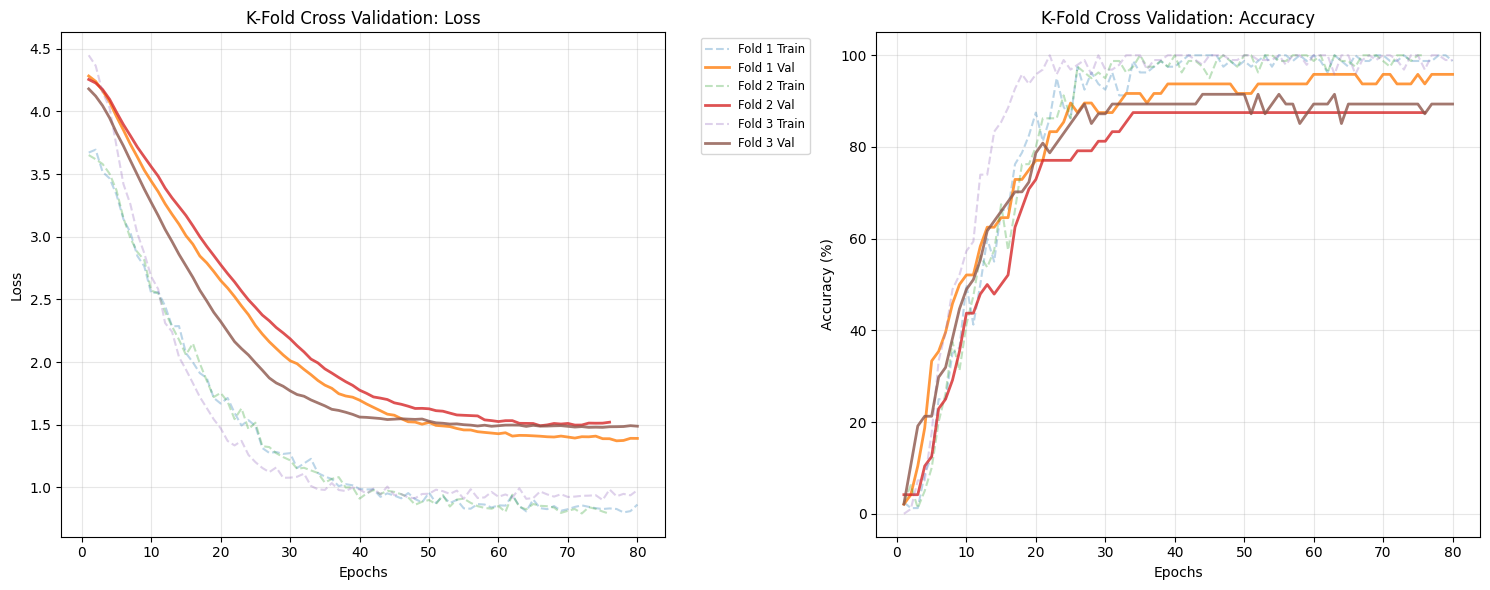

In [29]:
def plot_kfold_history(all_histories):
    plt.figure(figsize=(15, 6))

    # --- PLOT 1: LOSS ---
    plt.subplot(1, 2, 1)
    for i, h in enumerate(all_histories):
        epochs = range(1, len(h['train_loss']) + 1)
        # Plot garis tipis untuk setiap fold
        plt.plot(epochs, h['train_loss'], alpha=0.3, linestyle='--', label=f'Fold {i+1} Train')
        plt.plot(epochs, h['val_loss'], alpha=0.8, linewidth=2, label=f'Fold {i+1} Val')

    plt.title('K-Fold Cross Validation: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    # --- PLOT 2: ACCURACY ---
    plt.subplot(1, 2, 2)
    for i, h in enumerate(all_histories):
        epochs = range(1, len(h['train_acc']) + 1)
        # Plot garis tipis untuk setiap fold
        plt.plot(epochs, h['train_acc'], alpha=0.3, linestyle='--', label=f'Fold {i+1} Train')
        plt.plot(epochs, h['val_acc'], alpha=0.8, linewidth=2, label=f'Fold {i+1} Val')

    plt.title('K-Fold Cross Validation: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, alpha=0.3)
    # plt.legend() # Legend dimatikan di kanan agar tidak penuh

    plt.tight_layout()
    plt.show()

# Jalankan plotting
plot_kfold_history(all_folds_history)

In [30]:
print("\n=== AGGREGATED CLASSIFICATION REPORT (Semua Folds) ===")

# Gunakan np.arange agar tidak error jika ada kelas yang hilang
all_indices = np.arange(len(list_kelas))

print(classification_report(
    global_true_labels,
    global_pred_labels,
    labels=all_indices,
    target_names=list_kelas,
    zero_division=0
))


=== AGGREGATED CLASSIFICATION REPORT (Semua Folds) ===
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       1.00      0.50      0.67         2
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00         2
             Ahmad Faqih Hasani       1.00      1.00      1.00         2
                   Aldi Sanjaya       1.00      1.00      1.00         2
                        Alfajar       1.00      1.00      1.00         2
            Alief Fathur Rahman       1.00      1.00      1.00         2
 Arkan Hariz Chandrawinata Liem       0.67      1.00      0.80         2
               Bayu Ega Ferdana       1.00      1.00      1.00         2
          Bayu Prameswara Haris       1.00      0.50      0.67         2
           Bezalel Samuel Manik       1.00      1.00      1.00         2
           Bintang Fikri Fauzan       0.50      0.50      0.50         2
              Boy Sandro Sigiro       1.00      1.00      1.00     


=== AGGREGATED CONFUSION MATRIX ===


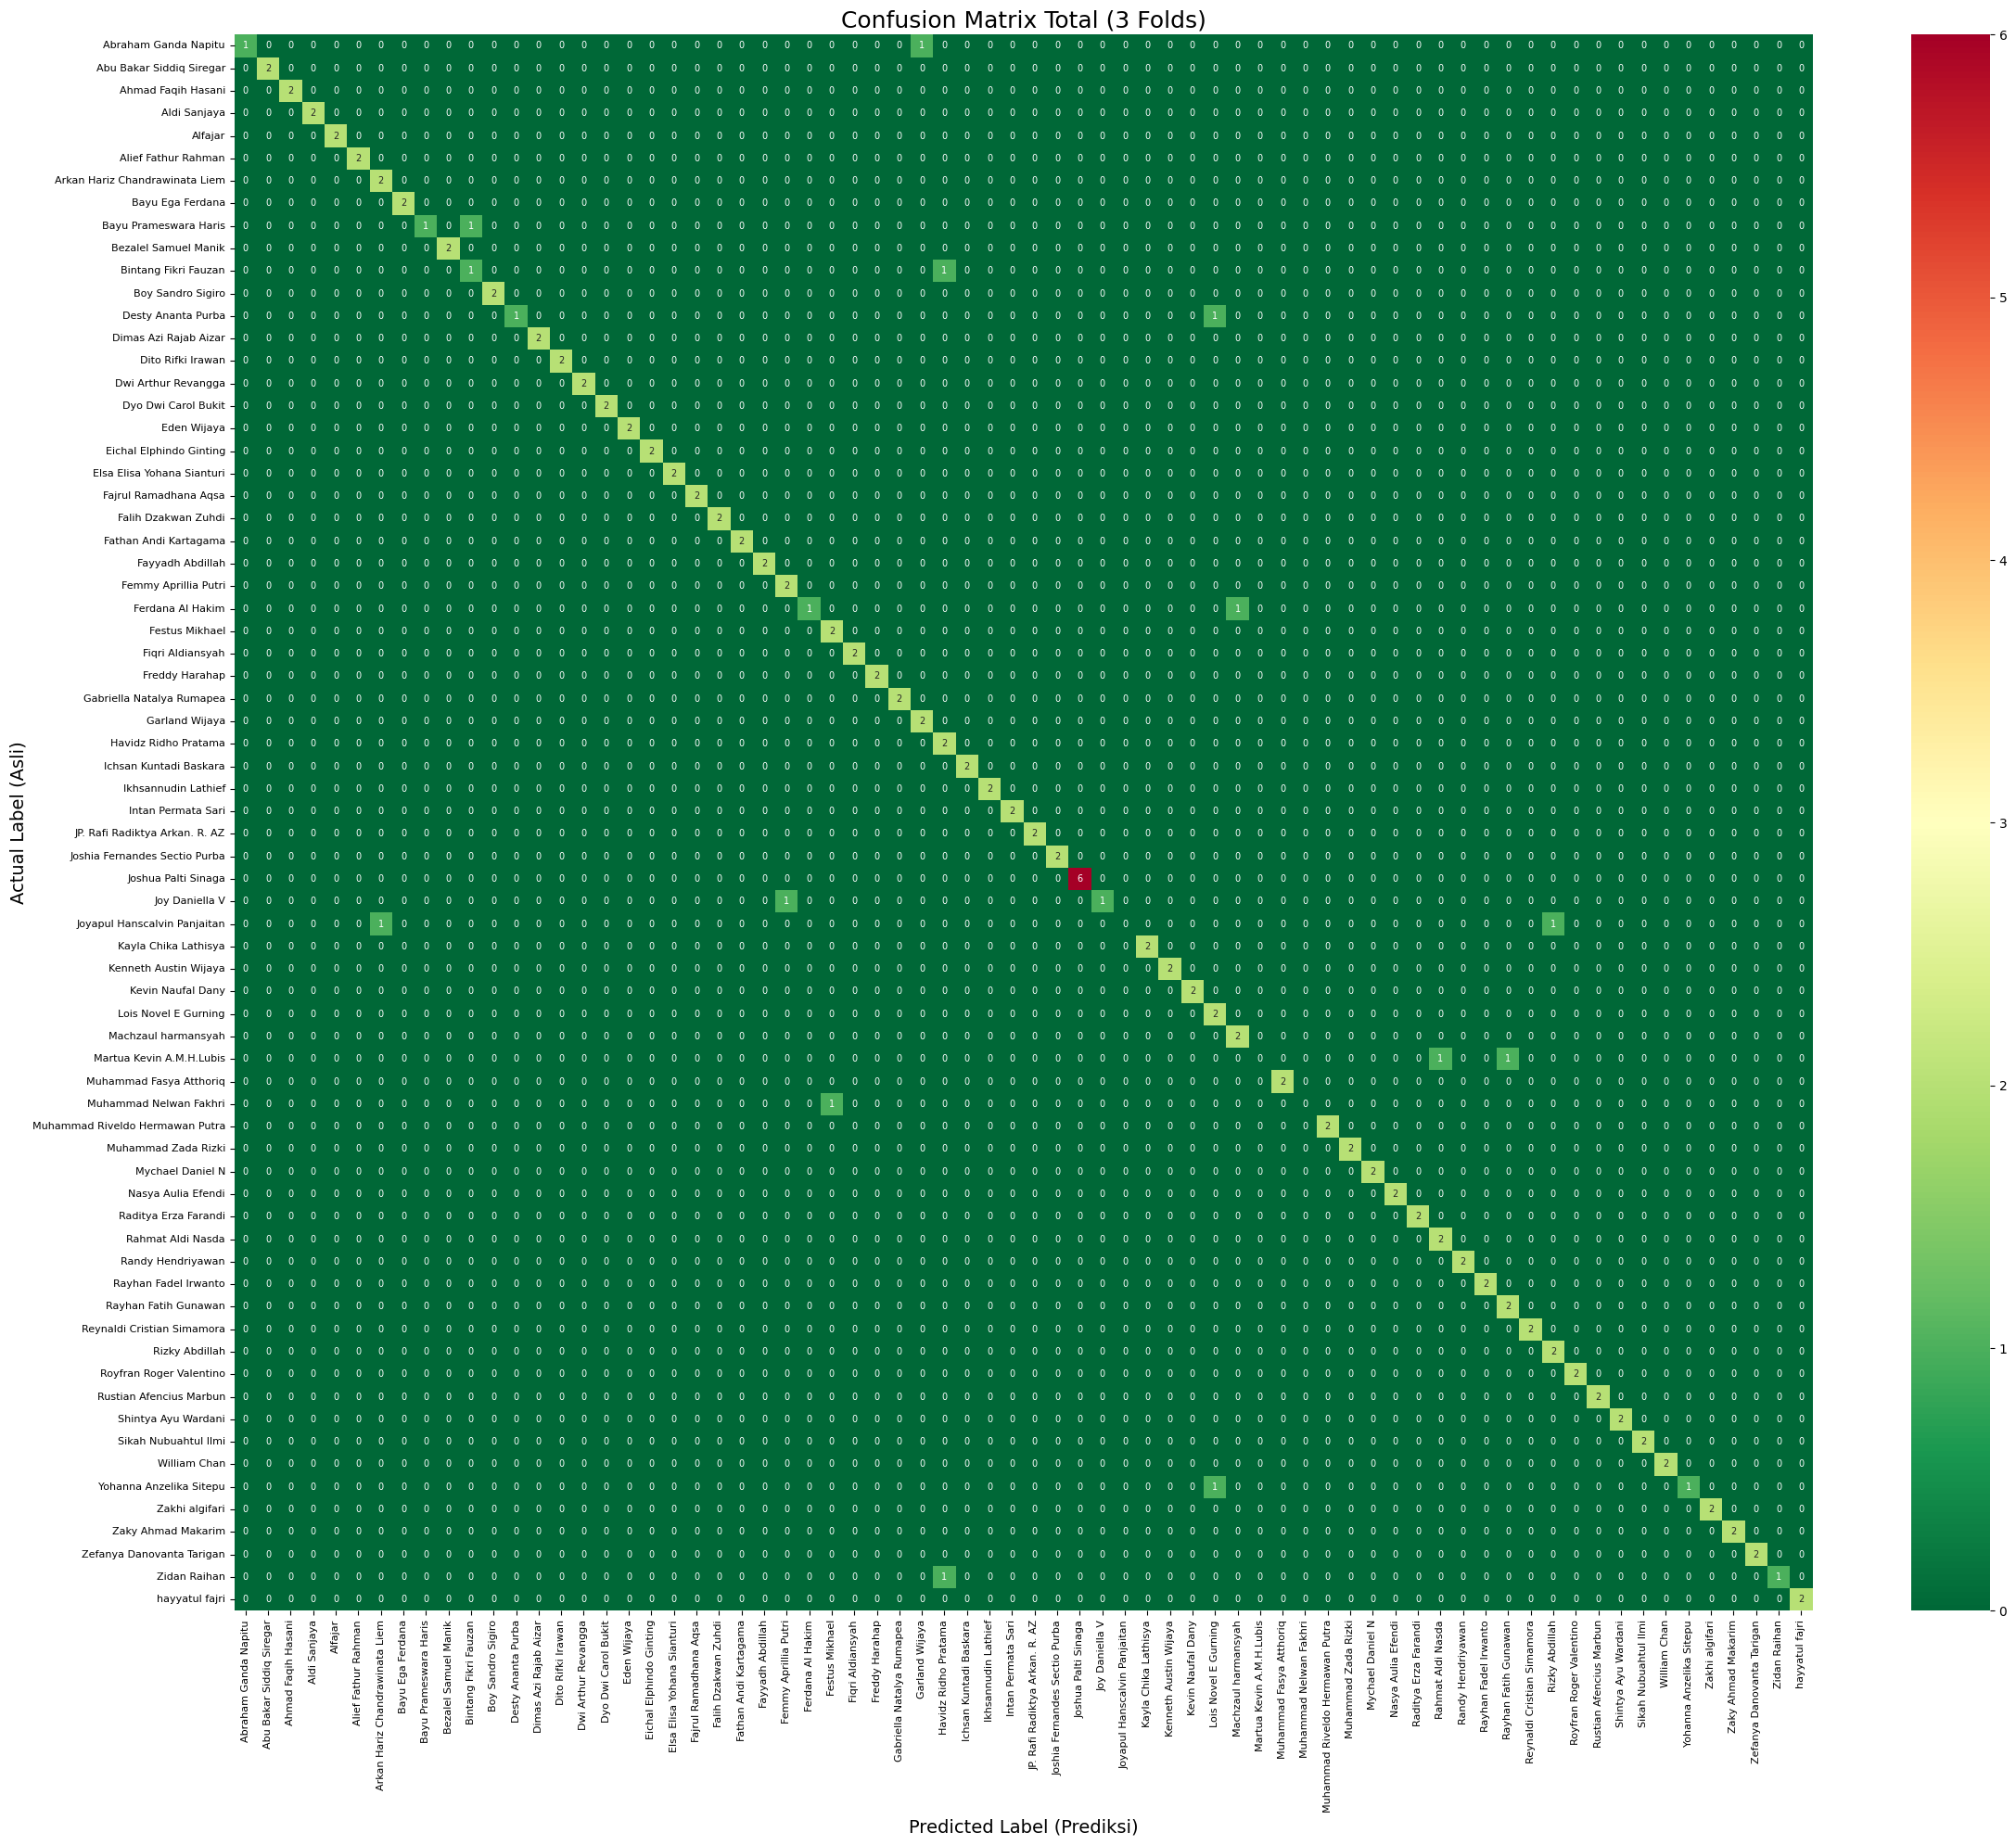

In [31]:
print("\n=== AGGREGATED CONFUSION MATRIX ===")

cm = confusion_matrix(global_true_labels, global_pred_labels, labels=all_indices)

# Karena 70 kelas, kita buat plot yang SANGAT BESAR
plt.figure(figsize=(24, 20)) # Ukuran kanvas besar

sns.heatmap(
    cm,
    annot=True,           # Tampilkan angka
    fmt='d',              # Format angka bulat
    cmap='RdYlGn_r',      # Warna RGB (Red-Yellow-Green reversed)
    xticklabels=list_kelas,
    yticklabels=list_kelas,
    annot_kws={"size": 7} # Perkecil ukuran font angka agar muat
)

plt.ylabel('Actual Label (Asli)', fontsize=14)
plt.xlabel('Predicted Label (Prediksi)', fontsize=14)
plt.title(f'Confusion Matrix Total ({K_FOLDS} Folds)', fontsize=18)
plt.xticks(rotation=90, fontsize=8) # Putar label nama agar terbaca
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

In [32]:
# ==================== MODEL 2: MOBILENETV2 (Sudah diinisialisasi di Cell 12) ====================
# MobileNetV2 sudah ready dengan architecture:
# - Frozen backbone
# - Dual layer classifier: 512 → 70
# - Dropout p=0.5, p=0.4
print(f"\n{'='*70}")
print("✓ MobileNetV2 sudah diinisialisasi di Cell 12")
print(f"✓ Total parameter: {mobile_total:,}")
print(f"✓ Parameter trainable: {mobile_trainable:,}")
print(f"{'='*70}")



✓ MobileNetV2 sudah diinisialisasi di Cell 12
✓ Total parameter: 2,915,654
✓ Parameter trainable: 691,782


In [33]:
def create_mobilenet_model(n_classes, target_device, dropout_rates=(0.5, 0.4)):
    """Factory function untuk MobileNetV2 dengan dual layer head
    
    Args:
        n_classes: Jumlah kelas output
        target_device: Device untuk model (cuda/cpu)
        dropout_rates: Tuple berisi 2 dropout rates (default: 0.5, 0.4)
    """
    # Inisialisasi model dengan pretrained weights dari ImageNet
    net = models.mobilenet_v2(pretrained=True)
    
    # Freeze backbone layers
    for p in net.parameters():
        p.requires_grad = False
    
    # Ambil dimensi fitur
    feat_dim = net.classifier[1].in_features
    
    # Dual layer head (lebih ringan dari InceptionResnetV1)
    net.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rates[0]),
        nn.Linear(feat_dim, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout_rates[1]),
        nn.Linear(512, n_classes)
    )
    
    return net.to(target_device)


In [34]:
# ==================== K-FOLD TRAINING MOBILENETV2 ====================
K_FOLDS_MOBILE = 3

# ⚠️ PENTING: Gunakan subset_train (sudah exclude test set) untuk K-Fold
train_labels_mobile = [complete_dataset.targets[i] for i in subset_train.indices]

# Inisialisasi K-Fold
skf_mobile = StratifiedKFold(n_splits=K_FOLDS_MOBILE, shuffle=True, random_state=42)

global_true_labels_mobile = []
global_pred_labels_mobile = []
all_folds_history_mobile = []

print(f"\n{'='*70}")
print(f"MEMULAI {K_FOLDS_MOBILE}-FOLD CROSS VALIDATION - MOBILENETV2")
print(f"{'='*70}")
print(f"Dataset untuk K-Fold: {len(subset_train)} samples (TANPA test set)")
print(f"Test set terpisah: {len(subset_test)} samples\n")

for fold, (train_idx, val_idx) in enumerate(skf_mobile.split(np.zeros(len(train_labels_mobile)), train_labels_mobile)):

    # 1. Split Data - mapping ke indices asli
    actual_train_idx = [subset_train.indices[i] for i in train_idx]
    actual_val_idx = [subset_train.indices[i] for i in val_idx]
    
    train_subset = Subset(complete_dataset, actual_train_idx)
    val_subset = Subset(complete_dataset, actual_val_idx)

    # 2. Terapkan Transform (Train=Augment, Val=Bersih)
    train_fold_dataset = DatasetWithTransform(train_subset, transform_pipeline=transform_train)
    val_fold_dataset = DatasetWithTransform(val_subset, transform_pipeline=transform_eval)

    # 3. DataLoader (num_workers=0 untuk Windows)
    train_loader_fold = DataLoader(train_fold_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
    val_loader_fold = DataLoader(val_fold_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # 4. RESET MODEL & OPTIMIZER (Wajib Fresh Instance)
    model_fold = create_mobilenet_model(n_classes=len(complete_dataset.classes), target_device=device)

    optimizer_fold = optim.AdamW(
        filter(lambda p: p.requires_grad, model_fold.parameters()),
        lr=1e-3,
        weight_decay=1e-2
    )

    scheduler_fold = lr_scheduler.CosineAnnealingLR(optimizer_fold, T_max=NUM_EPOCHS, eta_min=1e-6)
    criterion_fold = nn.CrossEntropyLoss(label_smoothing=0.1)

    # 5. Jalankan Training Fold Tersebut
    history, fold_preds, fold_labels = execute_training(
          model_fold,
          train_loader_fold,
          val_loader_fold,
          criterion_fold,
          optimizer_fold,
          scheduler_fold,
          NUM_EPOCHS,
          PATIENCE,
          device,
          K_FOLDS_MOBILE,
          fold
      )
    
    # Kumpulkan hasil fold ini ke wadah global
    all_folds_history_mobile.append(history)
    global_true_labels_mobile.extend(fold_labels)
    global_pred_labels_mobile.extend(fold_preds)

print("\nCross Validation MobileNetV2 Selesai.")


c:\Users\asus\miniconda3\envs\RBT\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\asus\miniconda3\envs\RBT\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\asus\miniconda3\envs\RBT\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



MEMULAI 3-FOLD CROSS VALIDATION - MOBILENETV2
Dataset untuk K-Fold: 143 samples (TANPA test set)
Test set terpisah: 70 samples


>>> Memulai Training Fold 1 (Gradient Accum: 2, Warmup: 5 epochs) <<<


   Train Loss: 3.6159 Acc: 2.50% | Val Loss: 4.2358 Acc: 2.08% | LR: 2.00e-04 | Grad: 3.626
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.6036 Acc: 1.25% | Val Loss: 4.2444 Acc: 0.00% | LR: 4.00e-04 | Grad: 3.937


   Train Loss: 3.5775 Acc: 1.25% | Val Loss: 4.2622 Acc: 4.17% | LR: 6.00e-04 | Grad: 4.030


   Train Loss: 3.5205 Acc: 3.75% | Val Loss: 4.2846 Acc: 4.17% | LR: 8.00e-04 | Grad: 4.040


   Train Loss: 3.4982 Acc: 8.75% | Val Loss: 4.3094 Acc: 4.17% | LR: 1.00e-03 | Grad: 4.097


   Train Loss: 3.4346 Acc: 2.50% | Val Loss: 4.3181 Acc: 4.17% | LR: 1.00e-03 | Grad: 4.246


   Train Loss: 3.4031 Acc: 8.75% | Val Loss: 4.3141 Acc: 4.17% | LR: 9.98e-04 | Grad: 4.509


   Train Loss: 3.3581 Acc: 11.25% | Val Loss: 4.2961 Acc: 4.17% | LR: 9.97e-04 | Grad: 4.458


   Train Loss: 3.2581 Acc: 15.00% | Val Loss: 4.2632 Acc: 6.25% | LR: 9.94e-04 | Grad: 4.523


   Train Loss: 3.1290 Acc: 18.75% | Val Loss: 4.2200 Acc: 6.25% | LR: 9.90e-04 | Grad: 4.657
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.2427 Acc: 18.75% | Val Loss: 4.1723 Acc: 6.25% | LR: 9.86e-04 | Grad: 4.703
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.0978 Acc: 15.00% | Val Loss: 4.1204 Acc: 6.25% | LR: 9.81e-04 | Grad: 4.930
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.0365 Acc: 18.75% | Val Loss: 4.0742 Acc: 6.25% | LR: 9.76e-04 | Grad: 5.048
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 3.0641 Acc: 12.50% | Val Loss: 4.0382 Acc: 4.17% | LR: 9.69e-04 | Grad: 5.179
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.8742 Acc: 25.00% | Val Loss: 3.9864 Acc: 8.33% | LR: 9.62e-04 | Grad: 5.419
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.9114 Acc: 30.00% | Val Loss: 3.9442 Acc: 8.33% | LR: 9.54e-04 | Grad: 5.430
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.8389 Acc: 33.75% | Val Loss: 3.9116 Acc: 6.25% | LR: 9.46e-04 | Grad: 5.606
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.7097 Acc: 32.50% | Val Loss: 3.8862 Acc: 8.33% | LR: 9.36e-04 | Grad: 5.668
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.6137 Acc: 41.25% | Val Loss: 3.8568 Acc: 10.42% | LR: 9.26e-04 | Grad: 5.684
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.5714 Acc: 32.50% | Val Loss: 3.8311 Acc: 10.42% | LR: 9.16e-04 | Grad: 5.868
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.5562 Acc: 36.25% | Val Loss: 3.8258 Acc: 12.50% | LR: 9.05e-04 | Grad: 5.718
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.5065 Acc: 43.75% | Val Loss: 3.7799 Acc: 12.50% | LR: 8.93e-04 | Grad: 6.023
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.5180 Acc: 38.75% | Val Loss: 3.7615 Acc: 8.33% | LR: 8.80e-04 | Grad: 5.877
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.2585 Acc: 46.25% | Val Loss: 3.7048 Acc: 8.33% | LR: 8.67e-04 | Grad: 5.766
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.2907 Acc: 43.75% | Val Loss: 3.6659 Acc: 6.25% | LR: 8.54e-04 | Grad: 6.355
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.3037 Acc: 50.00% | Val Loss: 3.6000 Acc: 16.67% | LR: 8.40e-04 | Grad: 6.043
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.3041 Acc: 45.00% | Val Loss: 3.5585 Acc: 16.67% | LR: 8.25e-04 | Grad: 6.019
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.0890 Acc: 57.50% | Val Loss: 3.4768 Acc: 25.00% | LR: 8.10e-04 | Grad: 6.029
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.0150 Acc: 62.50% | Val Loss: 3.4293 Acc: 29.17% | LR: 7.94e-04 | Grad: 5.663
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.1657 Acc: 57.50% | Val Loss: 3.3957 Acc: 31.25% | LR: 7.78e-04 | Grad: 6.153
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.0536 Acc: 56.25% | Val Loss: 3.3762 Acc: 35.42% | LR: 7.61e-04 | Grad: 6.026
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.0758 Acc: 51.25% | Val Loss: 3.3716 Acc: 35.42% | LR: 7.45e-04 | Grad: 6.202
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.9637 Acc: 67.50% | Val Loss: 3.3353 Acc: 31.25% | LR: 7.27e-04 | Grad: 5.554
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.8980 Acc: 61.25% | Val Loss: 3.3163 Acc: 25.00% | LR: 7.10e-04 | Grad: 5.998
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 2.0039 Acc: 60.00% | Val Loss: 3.3277 Acc: 27.08% | LR: 6.92e-04 | Grad: 6.034


   Train Loss: 1.8656 Acc: 63.75% | Val Loss: 3.3484 Acc: 27.08% | LR: 6.73e-04 | Grad: 5.804


   Train Loss: 1.9297 Acc: 63.75% | Val Loss: 3.3142 Acc: 27.08% | LR: 6.55e-04 | Grad: 5.982
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.9559 Acc: 62.50% | Val Loss: 3.2919 Acc: 29.17% | LR: 6.36e-04 | Grad: 6.205
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.6831 Acc: 71.25% | Val Loss: 3.2594 Acc: 31.25% | LR: 6.17e-04 | Grad: 5.926
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.7988 Acc: 66.25% | Val Loss: 3.1958 Acc: 31.25% | LR: 5.98e-04 | Grad: 5.763
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.7783 Acc: 68.75% | Val Loss: 3.1856 Acc: 31.25% | LR: 5.79e-04 | Grad: 5.899
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.8204 Acc: 67.50% | Val Loss: 3.1813 Acc: 31.25% | LR: 5.59e-04 | Grad: 5.892
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.6789 Acc: 72.50% | Val Loss: 3.1492 Acc: 35.42% | LR: 5.40e-04 | Grad: 5.779
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.8164 Acc: 67.50% | Val Loss: 3.1498 Acc: 35.42% | LR: 5.20e-04 | Grad: 6.262


   Train Loss: 1.5581 Acc: 75.00% | Val Loss: 3.1314 Acc: 37.50% | LR: 5.01e-04 | Grad: 5.134
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5352 Acc: 82.50% | Val Loss: 3.1371 Acc: 37.50% | LR: 4.81e-04 | Grad: 5.295


   Train Loss: 1.6238 Acc: 71.25% | Val Loss: 3.1176 Acc: 37.50% | LR: 4.61e-04 | Grad: 5.650
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.6169 Acc: 77.50% | Val Loss: 3.0846 Acc: 37.50% | LR: 4.42e-04 | Grad: 5.713
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5727 Acc: 77.50% | Val Loss: 3.0946 Acc: 39.58% | LR: 4.22e-04 | Grad: 5.635


   Train Loss: 1.5916 Acc: 76.25% | Val Loss: 3.0937 Acc: 39.58% | LR: 4.03e-04 | Grad: 5.707


   Train Loss: 1.6055 Acc: 77.50% | Val Loss: 3.0839 Acc: 37.50% | LR: 3.84e-04 | Grad: 5.583
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5804 Acc: 72.50% | Val Loss: 3.0479 Acc: 37.50% | LR: 3.65e-04 | Grad: 5.498
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.6243 Acc: 70.00% | Val Loss: 3.0507 Acc: 37.50% | LR: 3.46e-04 | Grad: 5.707


   Train Loss: 1.5901 Acc: 71.25% | Val Loss: 3.0288 Acc: 35.42% | LR: 3.28e-04 | Grad: 5.655
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5649 Acc: 78.75% | Val Loss: 3.0019 Acc: 37.50% | LR: 3.09e-04 | Grad: 5.575
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5121 Acc: 77.50% | Val Loss: 3.0293 Acc: 33.33% | LR: 2.91e-04 | Grad: 5.016


   Train Loss: 1.4119 Acc: 77.50% | Val Loss: 3.0007 Acc: 39.58% | LR: 2.74e-04 | Grad: 5.107
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5480 Acc: 71.25% | Val Loss: 2.9978 Acc: 41.67% | LR: 2.56e-04 | Grad: 5.626
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.4777 Acc: 75.00% | Val Loss: 2.9978 Acc: 39.58% | LR: 2.40e-04 | Grad: 5.490
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.4487 Acc: 76.25% | Val Loss: 2.9669 Acc: 39.58% | LR: 2.23e-04 | Grad: 4.985
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.4481 Acc: 82.50% | Val Loss: 2.9223 Acc: 39.58% | LR: 2.07e-04 | Grad: 5.311
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5036 Acc: 78.75% | Val Loss: 2.8948 Acc: 41.67% | LR: 1.91e-04 | Grad: 5.191
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.5294 Acc: 75.00% | Val Loss: 2.8806 Acc: 41.67% | LR: 1.76e-04 | Grad: 5.047
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.3981 Acc: 85.00% | Val Loss: 2.8857 Acc: 39.58% | LR: 1.61e-04 | Grad: 5.404


   Train Loss: 1.4524 Acc: 81.25% | Val Loss: 2.9179 Acc: 35.42% | LR: 1.47e-04 | Grad: 5.218


   Train Loss: 1.4582 Acc: 85.00% | Val Loss: 2.9306 Acc: 35.42% | LR: 1.34e-04 | Grad: 5.412


   Train Loss: 1.5142 Acc: 80.00% | Val Loss: 2.9164 Acc: 35.42% | LR: 1.21e-04 | Grad: 5.501


   Train Loss: 1.4692 Acc: 76.25% | Val Loss: 2.9029 Acc: 35.42% | LR: 1.08e-04 | Grad: 5.559


   Train Loss: 1.5358 Acc: 78.75% | Val Loss: 2.9060 Acc: 35.42% | LR: 9.64e-05 | Grad: 5.360


   Train Loss: 1.3919 Acc: 82.50% | Val Loss: 2.9152 Acc: 39.58% | LR: 8.52e-05 | Grad: 5.162


   Train Loss: 1.4310 Acc: 78.75% | Val Loss: 2.8888 Acc: 39.58% | LR: 7.46e-05 | Grad: 4.798


   Train Loss: 1.5277 Acc: 73.75% | Val Loss: 2.8804 Acc: 43.75% | LR: 6.47e-05 | Grad: 5.506
   -> Model Saved to best_model_fold_1.pth


   Train Loss: 1.4051 Acc: 81.25% | Val Loss: 2.9295 Acc: 41.67% | LR: 5.54e-05 | Grad: 4.951


   Train Loss: 1.4701 Acc: 80.00% | Val Loss: 2.9319 Acc: 41.67% | LR: 4.69e-05 | Grad: 5.183


   Train Loss: 1.3430 Acc: 83.75% | Val Loss: 2.9229 Acc: 39.58% | LR: 3.90e-05 | Grad: 4.712


   Train Loss: 1.5073 Acc: 76.25% | Val Loss: 2.8959 Acc: 39.58% | LR: 3.19e-05 | Grad: 5.484


   Train Loss: 1.3335 Acc: 87.50% | Val Loss: 2.9290 Acc: 37.50% | LR: 2.54e-05 | Grad: 4.801


   Train Loss: 1.4867 Acc: 80.00% | Val Loss: 2.9017 Acc: 43.75% | LR: 1.98e-05 | Grad: 5.234


   Train Loss: 1.4601 Acc: 76.25% | Val Loss: 2.9055 Acc: 39.58% | LR: 1.48e-05 | Grad: 5.459


   Train Loss: 1.4196 Acc: 85.00% | Val Loss: 2.8893 Acc: 41.67% | LR: 1.06e-05 | Grad: 4.896
Selesai Fold 1. Best Val Loss: 2.8804

>>> Memulai Training Fold 2 (Gradient Accum: 2, Warmup: 5 epochs) <<<

>>> Memulai Training Fold 2 (Gradient Accum: 2, Warmup: 5 epochs) <<<


   Train Loss: 3.6134 Acc: 0.00% | Val Loss: 4.2769 Acc: 0.00% | LR: 2.00e-04 | Grad: 3.593
   -> Model Saved to best_model_fold_2.pth


   Train Loss: 3.5647 Acc: 2.50% | Val Loss: 4.2890 Acc: 2.08% | LR: 4.00e-04 | Grad: 3.973


   Train Loss: 3.5183 Acc: 7.50% | Val Loss: 4.3020 Acc: 4.17% | LR: 6.00e-04 | Grad: 3.998


   Train Loss: 3.5194 Acc: 3.75% | Val Loss: 4.3236 Acc: 4.17% | LR: 8.00e-04 | Grad: 4.157


   Train Loss: 3.4035 Acc: 5.00% | Val Loss: 4.3748 Acc: 4.17% | LR: 1.00e-03 | Grad: 4.225


   Train Loss: 3.4104 Acc: 6.25% | Val Loss: 4.4173 Acc: 4.17% | LR: 1.00e-03 | Grad: 4.354


   Train Loss: 3.3348 Acc: 7.50% | Val Loss: 4.4445 Acc: 4.17% | LR: 9.98e-04 | Grad: 4.546


   Train Loss: 3.3400 Acc: 10.00% | Val Loss: 4.4474 Acc: 4.17% | LR: 9.97e-04 | Grad: 4.773


   Train Loss: 3.2322 Acc: 17.50% | Val Loss: 4.4088 Acc: 4.17% | LR: 9.94e-04 | Grad: 4.748


   Train Loss: 3.2943 Acc: 12.50% | Val Loss: 4.3535 Acc: 4.17% | LR: 9.90e-04 | Grad: 4.859


   Train Loss: 3.1544 Acc: 17.50% | Val Loss: 4.2867 Acc: 4.17% | LR: 9.86e-04 | Grad: 5.017
   Early stopping di Epoch 11
Selesai Fold 2. Best Val Loss: 4.2769

>>> Memulai Training Fold 3 (Gradient Accum: 2, Warmup: 5 epochs) <<<

>>> Memulai Training Fold 3 (Gradient Accum: 2, Warmup: 5 epochs) <<<


   Train Loss: 4.3177 Acc: 0.00% | Val Loss: 4.2611 Acc: 2.13% | LR: 2.00e-04 | Grad: 3.638
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 4.2281 Acc: 1.04% | Val Loss: 4.2716 Acc: 2.13% | LR: 4.00e-04 | Grad: 3.598


   Train Loss: 4.1594 Acc: 8.33% | Val Loss: 4.3055 Acc: 4.26% | LR: 6.00e-04 | Grad: 3.605


   Train Loss: 4.1146 Acc: 7.29% | Val Loss: 4.3643 Acc: 4.26% | LR: 8.00e-04 | Grad: 3.643


   Train Loss: 4.0272 Acc: 9.38% | Val Loss: 4.4182 Acc: 4.26% | LR: 1.00e-03 | Grad: 3.809


   Train Loss: 3.9324 Acc: 14.58% | Val Loss: 4.4467 Acc: 4.26% | LR: 1.00e-03 | Grad: 4.014


   Train Loss: 3.8614 Acc: 15.62% | Val Loss: 4.4479 Acc: 4.26% | LR: 9.98e-04 | Grad: 4.360


   Train Loss: 3.8305 Acc: 16.67% | Val Loss: 4.3703 Acc: 4.26% | LR: 9.97e-04 | Grad: 4.466


   Train Loss: 3.6761 Acc: 21.88% | Val Loss: 4.2714 Acc: 4.26% | LR: 9.94e-04 | Grad: 4.503


   Train Loss: 3.5424 Acc: 28.12% | Val Loss: 4.1902 Acc: 4.26% | LR: 9.90e-04 | Grad: 4.621
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.4538 Acc: 32.29% | Val Loss: 4.1114 Acc: 6.38% | LR: 9.86e-04 | Grad: 4.807
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.3528 Acc: 27.08% | Val Loss: 4.0702 Acc: 8.51% | LR: 9.81e-04 | Grad: 4.850
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.2575 Acc: 31.25% | Val Loss: 4.0223 Acc: 8.51% | LR: 9.76e-04 | Grad: 5.110
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.0677 Acc: 36.46% | Val Loss: 3.9820 Acc: 8.51% | LR: 9.69e-04 | Grad: 5.038
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.1025 Acc: 35.42% | Val Loss: 3.9213 Acc: 6.38% | LR: 9.62e-04 | Grad: 5.188
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 3.0129 Acc: 38.54% | Val Loss: 3.8547 Acc: 12.77% | LR: 9.54e-04 | Grad: 5.353
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.7513 Acc: 41.67% | Val Loss: 3.8044 Acc: 14.89% | LR: 9.46e-04 | Grad: 5.253
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.7606 Acc: 47.92% | Val Loss: 3.7286 Acc: 21.28% | LR: 9.36e-04 | Grad: 5.335
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.5525 Acc: 55.21% | Val Loss: 3.6481 Acc: 19.15% | LR: 9.26e-04 | Grad: 5.353
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.5161 Acc: 57.29% | Val Loss: 3.5873 Acc: 17.02% | LR: 9.16e-04 | Grad: 5.517
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.3930 Acc: 57.29% | Val Loss: 3.5397 Acc: 19.15% | LR: 9.05e-04 | Grad: 5.344
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.4293 Acc: 57.29% | Val Loss: 3.4724 Acc: 25.53% | LR: 8.93e-04 | Grad: 5.573
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.2771 Acc: 61.46% | Val Loss: 3.4476 Acc: 23.40% | LR: 8.80e-04 | Grad: 5.479
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.2443 Acc: 60.42% | Val Loss: 3.3872 Acc: 25.53% | LR: 8.67e-04 | Grad: 5.371
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.1201 Acc: 62.50% | Val Loss: 3.3686 Acc: 23.40% | LR: 8.54e-04 | Grad: 5.085
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.9782 Acc: 71.88% | Val Loss: 3.3272 Acc: 31.91% | LR: 8.40e-04 | Grad: 5.001
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.0873 Acc: 64.58% | Val Loss: 3.3058 Acc: 31.91% | LR: 8.25e-04 | Grad: 5.132
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 2.0900 Acc: 64.58% | Val Loss: 3.2895 Acc: 29.79% | LR: 8.10e-04 | Grad: 5.350
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.9761 Acc: 67.71% | Val Loss: 3.2300 Acc: 36.17% | LR: 7.94e-04 | Grad: 5.121
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.9461 Acc: 70.83% | Val Loss: 3.2062 Acc: 34.04% | LR: 7.78e-04 | Grad: 4.983
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.7444 Acc: 75.00% | Val Loss: 3.1783 Acc: 36.17% | LR: 7.61e-04 | Grad: 4.680
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.7917 Acc: 77.08% | Val Loss: 3.1795 Acc: 36.17% | LR: 7.45e-04 | Grad: 4.710


   Train Loss: 1.8429 Acc: 75.00% | Val Loss: 3.1782 Acc: 36.17% | LR: 7.27e-04 | Grad: 5.027
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.8125 Acc: 67.71% | Val Loss: 3.1461 Acc: 38.30% | LR: 7.10e-04 | Grad: 5.094
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.7351 Acc: 79.17% | Val Loss: 3.1089 Acc: 38.30% | LR: 6.92e-04 | Grad: 4.640
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.6392 Acc: 83.33% | Val Loss: 3.0863 Acc: 36.17% | LR: 6.73e-04 | Grad: 4.353
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.7234 Acc: 83.33% | Val Loss: 3.0482 Acc: 38.30% | LR: 6.55e-04 | Grad: 4.964
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.6489 Acc: 78.12% | Val Loss: 2.9931 Acc: 38.30% | LR: 6.36e-04 | Grad: 4.627
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.6609 Acc: 81.25% | Val Loss: 2.9333 Acc: 40.43% | LR: 6.17e-04 | Grad: 4.611
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.6252 Acc: 78.12% | Val Loss: 2.9435 Acc: 44.68% | LR: 5.98e-04 | Grad: 4.464


   Train Loss: 1.6779 Acc: 78.12% | Val Loss: 2.9618 Acc: 40.43% | LR: 5.79e-04 | Grad: 4.720


   Train Loss: 1.6177 Acc: 81.25% | Val Loss: 2.9934 Acc: 42.55% | LR: 5.59e-04 | Grad: 4.450


   Train Loss: 1.5997 Acc: 78.12% | Val Loss: 3.0016 Acc: 38.30% | LR: 5.40e-04 | Grad: 4.548


   Train Loss: 1.5866 Acc: 79.17% | Val Loss: 2.9998 Acc: 38.30% | LR: 5.20e-04 | Grad: 4.522


   Train Loss: 1.4186 Acc: 90.62% | Val Loss: 2.9866 Acc: 40.43% | LR: 5.01e-04 | Grad: 4.106


   Train Loss: 1.4944 Acc: 86.46% | Val Loss: 2.9685 Acc: 44.68% | LR: 4.81e-04 | Grad: 4.254


   Train Loss: 1.5175 Acc: 87.50% | Val Loss: 2.9670 Acc: 42.55% | LR: 4.61e-04 | Grad: 4.041


   Train Loss: 1.5057 Acc: 86.46% | Val Loss: 2.9324 Acc: 42.55% | LR: 4.42e-04 | Grad: 4.158
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.5018 Acc: 85.42% | Val Loss: 2.9237 Acc: 40.43% | LR: 4.22e-04 | Grad: 4.254
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.5657 Acc: 82.29% | Val Loss: 2.8888 Acc: 40.43% | LR: 4.03e-04 | Grad: 4.345
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.4766 Acc: 81.25% | Val Loss: 2.9163 Acc: 40.43% | LR: 3.84e-04 | Grad: 4.267


   Train Loss: 1.6065 Acc: 79.17% | Val Loss: 2.9287 Acc: 40.43% | LR: 3.65e-04 | Grad: 4.566


   Train Loss: 1.4129 Acc: 88.54% | Val Loss: 2.9530 Acc: 40.43% | LR: 3.46e-04 | Grad: 4.045


   Train Loss: 1.3659 Acc: 87.50% | Val Loss: 2.9431 Acc: 38.30% | LR: 3.28e-04 | Grad: 3.736


   Train Loss: 1.4062 Acc: 87.50% | Val Loss: 2.9004 Acc: 40.43% | LR: 3.09e-04 | Grad: 3.759


   Train Loss: 1.4456 Acc: 92.71% | Val Loss: 2.8896 Acc: 40.43% | LR: 2.91e-04 | Grad: 4.133


   Train Loss: 1.3467 Acc: 92.71% | Val Loss: 2.8708 Acc: 40.43% | LR: 2.74e-04 | Grad: 3.635
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.3828 Acc: 89.58% | Val Loss: 2.8523 Acc: 40.43% | LR: 2.56e-04 | Grad: 3.947
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.4342 Acc: 85.42% | Val Loss: 2.8484 Acc: 40.43% | LR: 2.40e-04 | Grad: 3.940
   -> Model Saved to best_model_fold_3.pth


   Train Loss: 1.3790 Acc: 90.62% | Val Loss: 2.8530 Acc: 40.43% | LR: 2.23e-04 | Grad: 3.705


   Train Loss: 1.4074 Acc: 86.46% | Val Loss: 2.8601 Acc: 42.55% | LR: 2.07e-04 | Grad: 3.776


   Train Loss: 1.2886 Acc: 95.83% | Val Loss: 2.8519 Acc: 42.55% | LR: 1.91e-04 | Grad: 3.592


   Train Loss: 1.3876 Acc: 87.50% | Val Loss: 2.8672 Acc: 40.43% | LR: 1.76e-04 | Grad: 3.579


   Train Loss: 1.2963 Acc: 91.67% | Val Loss: 2.8784 Acc: 40.43% | LR: 1.61e-04 | Grad: 3.313


   Train Loss: 1.3174 Acc: 91.67% | Val Loss: 2.8750 Acc: 40.43% | LR: 1.47e-04 | Grad: 3.497


   Train Loss: 1.4245 Acc: 86.46% | Val Loss: 2.8588 Acc: 40.43% | LR: 1.34e-04 | Grad: 3.809


   Train Loss: 1.3651 Acc: 93.75% | Val Loss: 2.8697 Acc: 40.43% | LR: 1.21e-04 | Grad: 3.785


   Train Loss: 1.3717 Acc: 86.46% | Val Loss: 2.8808 Acc: 40.43% | LR: 1.08e-04 | Grad: 3.822


   Train Loss: 1.3996 Acc: 89.58% | Val Loss: 2.8626 Acc: 40.43% | LR: 9.64e-05 | Grad: 3.716
   Early stopping di Epoch 69
Selesai Fold 3. Best Val Loss: 2.8484

Cross Validation MobileNetV2 Selesai.


In [35]:
# ==================== SIMPAN MODEL TERBAIK MOBILENETV2 ====================
print("\n" + "="*70)
print("MENYIMPAN MODEL TERBAIK MOBILENETV2 DARI CROSS VALIDATION")
print("="*70)

# Cari fold dengan validation loss terkecil
best_fold_idx_mobile = 0
best_val_loss_mobile = float('inf')

for i, history in enumerate(all_folds_history_mobile):
    final_train_loss = history['train_loss'][-1]
    final_train_acc = history['train_acc'][-1]
    final_val_loss = history['val_loss'][-1]
    final_val_acc = history['val_acc'][-1]
    print(f"Fold {i+1} - Train Loss: {final_train_loss:.4f} | Train Acc: {final_train_acc:.2f}% | Val Loss: {final_val_loss:.4f} | Val Acc: {final_val_acc:.2f}%")
    
    if final_val_loss < best_val_loss_mobile:
        best_val_loss_mobile = final_val_loss
        best_fold_idx_mobile = i

# Ambil metrik terbaik
best_train_loss_mobile = all_folds_history_mobile[best_fold_idx_mobile]['train_loss'][-1]
best_train_acc_mobile = all_folds_history_mobile[best_fold_idx_mobile]['train_acc'][-1]
best_val_acc_mobile = all_folds_history_mobile[best_fold_idx_mobile]['val_acc'][-1]

print(f"\n{'='*70}")
print(f"🏆 MODEL TERBAIK MOBILENETV2: Fold {best_fold_idx_mobile+1}")
print(f"   Training Loss      : {best_train_loss_mobile:.4f}")
print(f"   Training Accuracy  : {best_train_acc_mobile:.2f}%")
print(f"   Validation Loss    : {best_val_loss_mobile:.4f}")
print(f"   Validation Accuracy: {best_val_acc_mobile:.2f}%")
print(f"{'='*70}")

# Path model terbaik yang sudah disimpan saat training
best_model_source_mobile = f"best_model_fold_{best_fold_idx_mobile+1}.pth"

# Copy ke final best model
final_best_model_path_mobile = "final_best_model_mobilenetv2.pth"
import shutil
shutil.copy(best_model_source_mobile, final_best_model_path_mobile)

print(f"\n✓ Model terbaik MobileNetV2 disimpan ke: {final_best_model_path_mobile}")
print(f"✓ Source: {best_model_source_mobile}")

# Simpan juga informasi model
model_info_mobile = {
    'best_fold': best_fold_idx_mobile + 1,
    'best_train_loss': float(best_train_loss_mobile),
    'best_train_accuracy': float(best_train_acc_mobile),
    'best_val_loss': float(best_val_loss_mobile),
    'best_val_accuracy': float(best_val_acc_mobile),
    'num_classes': len(complete_dataset.classes),
    'class_names': complete_dataset.classes,
    'image_size': TARGET_SIZE,
    'model_architecture': 'MobileNetV2',
    'pretrained_on': 'imagenet'
}

import json
with open('model_info_mobilenetv2.json', 'w') as f:
    json.dump(model_info_mobile, f, indent=4)

print(f"✓ Informasi model disimpan ke: model_info_mobilenetv2.json")
print(f"{'='*70}")


MENYIMPAN MODEL TERBAIK MOBILENETV2 DARI CROSS VALIDATION
Fold 1 - Train Loss: 1.4196 | Train Acc: 85.00% | Val Loss: 2.8893 | Val Acc: 41.67%
Fold 2 - Train Loss: 3.1544 | Train Acc: 17.50% | Val Loss: 4.2867 | Val Acc: 4.17%
Fold 3 - Train Loss: 1.3996 | Train Acc: 89.58% | Val Loss: 2.8626 | Val Acc: 40.43%

🏆 MODEL TERBAIK MOBILENETV2: Fold 3
   Training Loss      : 1.3996
   Training Accuracy  : 89.58%
   Validation Loss    : 2.8626
   Validation Accuracy: 40.43%

✓ Model terbaik MobileNetV2 disimpan ke: final_best_model_mobilenetv2.pth
✓ Source: best_model_fold_3.pth
✓ Informasi model disimpan ke: model_info_mobilenetv2.json


In [36]:
# ==================== CLASSIFICATION REPORT MOBILENETV2 ====================
print("\n=== AGGREGATED CLASSIFICATION REPORT MOBILENETV2 (Semua Folds) ===")

# Gunakan np.arange agar tidak error jika ada kelas yang hilang
all_indices_mobile = np.arange(len(list_kelas))

print(classification_report(
    global_true_labels_mobile,
    global_pred_labels_mobile,
    labels=all_indices_mobile,
    target_names=list_kelas,
    zero_division=0
))


=== AGGREGATED CLASSIFICATION REPORT MOBILENETV2 (Semua Folds) ===
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       0.00      0.00      0.00         2
       Abu Bakar Siddiq Siregar       0.40      1.00      0.57         2
             Ahmad Faqih Hasani       0.50      0.50      0.50         2
                   Aldi Sanjaya       0.50      0.50      0.50         2
                        Alfajar       1.00      0.50      0.67         2
            Alief Fathur Rahman       0.00      0.00      0.00         2
 Arkan Hariz Chandrawinata Liem       1.00      0.50      0.67         2
               Bayu Ega Ferdana       0.00      0.00      0.00         2
          Bayu Prameswara Haris       0.00      0.00      0.00         2
           Bezalel Samuel Manik       1.00      0.50      0.67         2
           Bintang Fikri Fauzan       0.00      0.00      0.00         2
              Boy Sandro Sigiro       0.00      0.00   


=== AGGREGATED CONFUSION MATRIX MOBILENETV2 ===


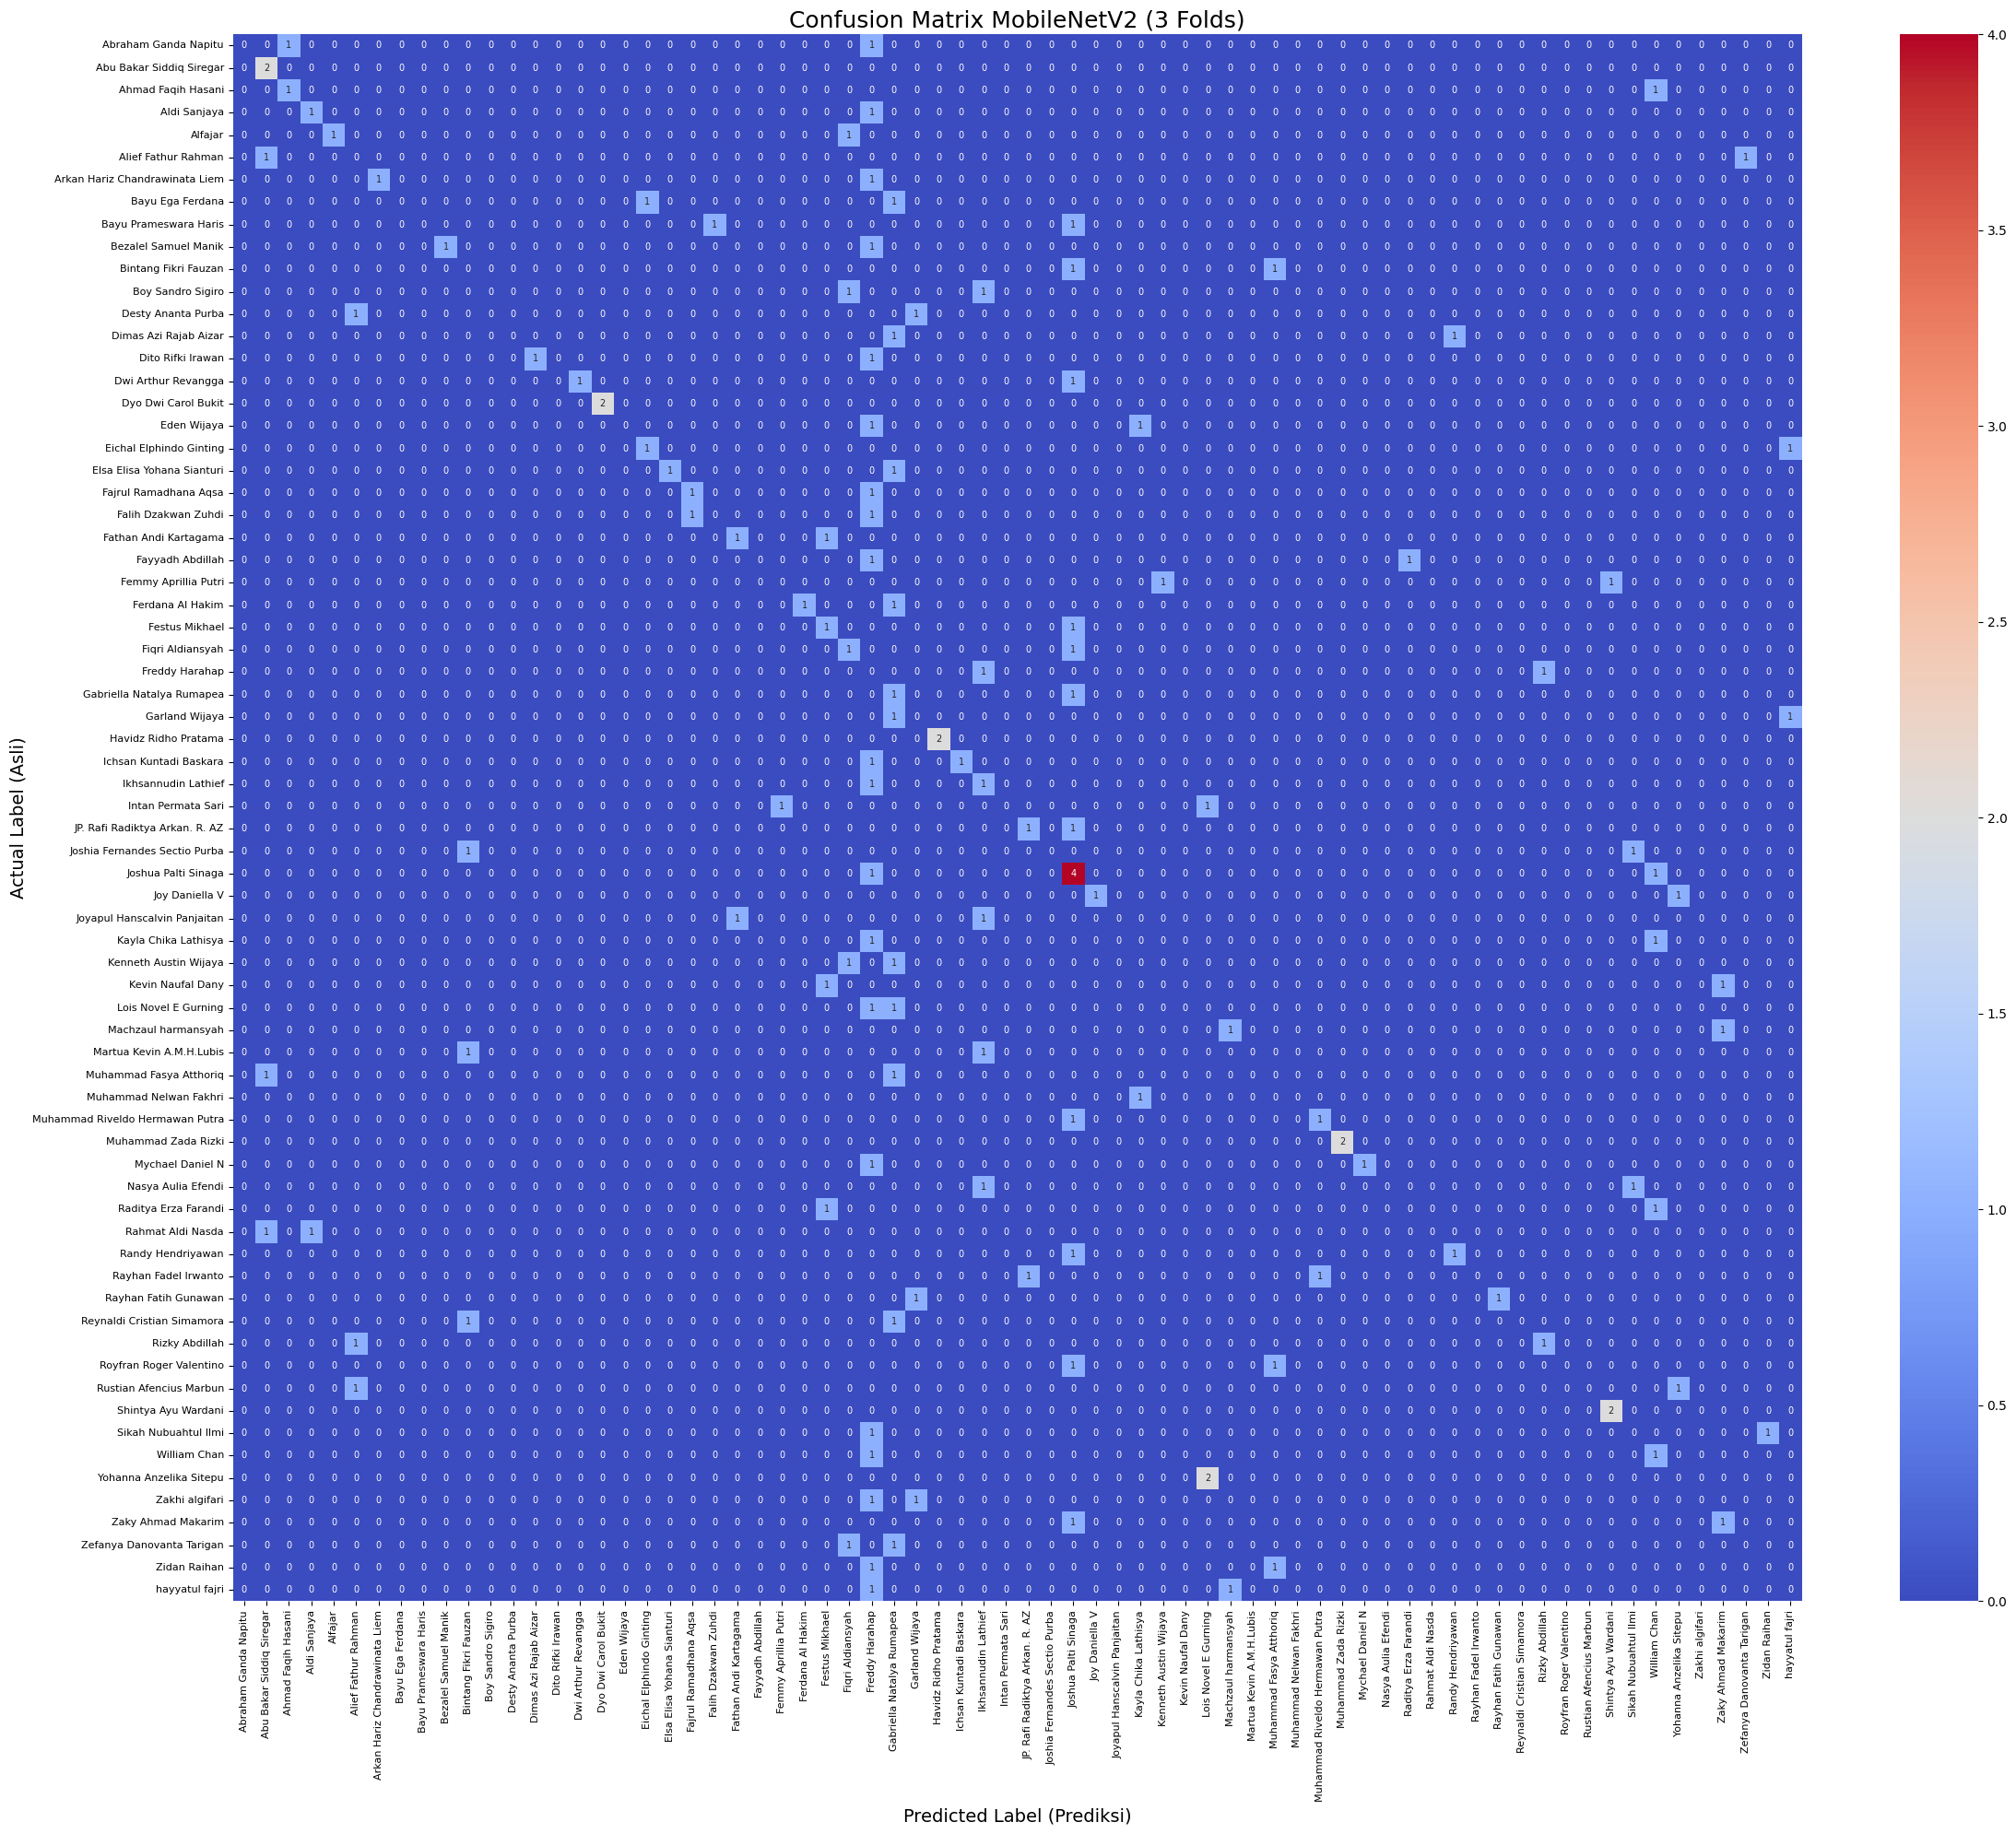

In [37]:
# ==================== CONFUSION MATRIX MOBILENETV2 ====================
print("\n=== AGGREGATED CONFUSION MATRIX MOBILENETV2 ===")

cm_mobile = confusion_matrix(global_true_labels_mobile, global_pred_labels_mobile, labels=all_indices_mobile)

# Karena 70 kelas, kita buat plot yang SANGAT BESAR
plt.figure(figsize=(24, 20)) # Ukuran kanvas besar

sns.heatmap(
    cm_mobile,
    annot=True,           # Tampilkan angka
    fmt='d',              # Format angka bulat
    cmap='coolwarm',      # Warna RGB (biru-putih-merah)
    xticklabels=list_kelas,
    yticklabels=list_kelas,
    annot_kws={"size": 7} # Perkecil ukuran font angka agar muat
)

plt.ylabel('Actual Label (Asli)', fontsize=14)
plt.xlabel('Predicted Label (Prediksi)', fontsize=14)
plt.title(f'Confusion Matrix MobileNetV2 ({K_FOLDS_MOBILE} Folds)', fontsize=18)
plt.xticks(rotation=90, fontsize=8) # Putar label nama agar terbaca
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


PERBANDINGAN MODEL TERBAIK: InceptionResnetV1 vs MobileNetV2

📊 TABEL PERBANDINGAN:
                             Model  Train Loss  Train Acc (%)  Val Loss  Val Acc (%)  Best Fold                Pretrained On
InceptionResnetV1\n(CASIA-WebFace)    0.863650      98.750000  1.391406    95.833333          1 CASIA-WebFace\n(Asian Faces)
           MobileNetV2\n(ImageNet)    1.399578      89.583333  2.862594    40.425532          3          ImageNet\n(General)

🏆 MODEL TERBAIK SECARA KESELURUHAN: InceptionResnetV1
   Validation Accuracy : 95.83%
   Validation Loss     : 1.3914


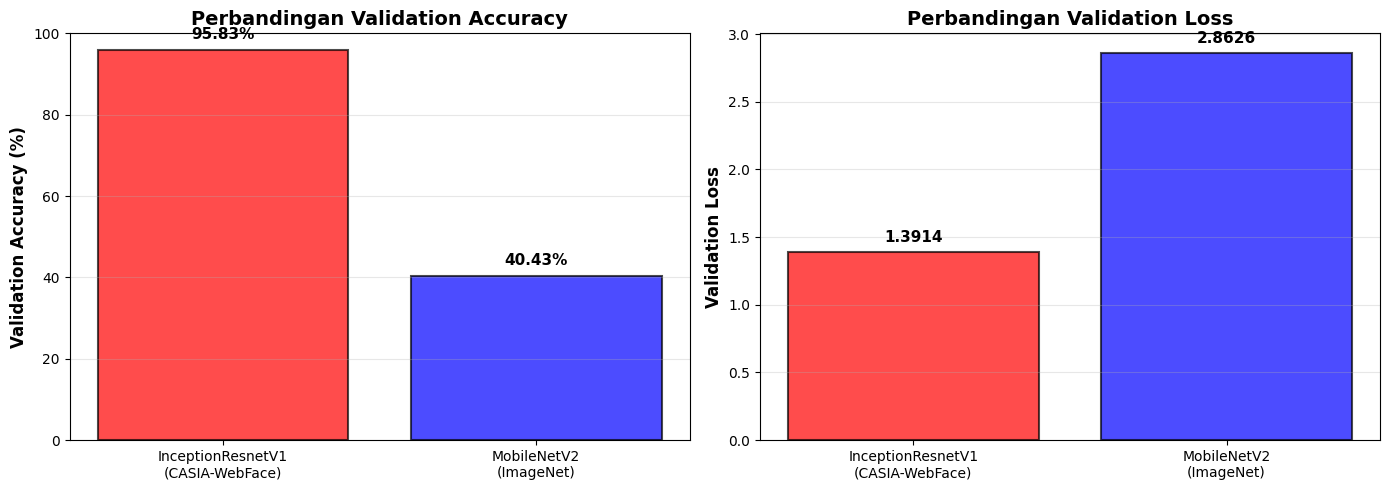


📝 ANALISIS PERBANDINGAN:
• InceptionResnetV1 dilatih dengan CASIA-WebFace (dataset wajah Asia)
  - Validation Accuracy: 95.83%
  - Validation Loss: 1.3914
  - Parameters: 23,783,238 (trainable: 300,614)

• MobileNetV2 dilatih dengan ImageNet (dataset general)
  - Validation Accuracy: 40.43%
  - Validation Loss: 2.8626
  - Parameters: 2,915,654 (trainable: 691,782)

• Selisih Accuracy: 55.41%
  → InceptionResnetV1 unggul signifikan


💡 KEUNGGULAN MOBILENETV2:
  • Lebih ringan dan efisien (parameter lebih sedikit)
  • Training lebih cepat dengan resource lebih sedikit
  • Cocok untuk deployment di mobile/edge devices


In [39]:
# ==================== PERBANDINGAN KEDUA MODEL ====================
print("\n" + "="*70)
print("PERBANDINGAN MODEL TERBAIK: InceptionResnetV1 vs MobileNetV2")
print("="*70)

# Data untuk perbandingan
models_comparison = {
    'Model': ['InceptionResnetV1\n(CASIA-WebFace)', 'MobileNetV2\n(ImageNet)'],
    'Train Loss': [best_train_loss, best_train_loss_mobile],
    'Train Acc (%)': [best_train_acc, best_train_acc_mobile],
    'Val Loss': [best_val_loss, best_val_loss_mobile],
    'Val Acc (%)': [best_val_acc, best_val_acc_mobile],
    'Best Fold': [best_fold_idx + 1, best_fold_idx_mobile + 1],
    'Pretrained On': ['CASIA-WebFace\n(Asian Faces)', 'ImageNet\n(General)']
}

# Tampilkan tabel perbandingan
import pandas as pd
df_comparison = pd.DataFrame(models_comparison)
print("\n📊 TABEL PERBANDINGAN:")
print(df_comparison.to_string(index=False))

# Tentukan model terbaik berdasarkan validation accuracy
if best_val_acc > best_val_acc_mobile:
    winner = "InceptionResnetV1"
    winner_acc = best_val_acc
    winner_loss = best_val_loss
else:
    winner = "MobileNetV2"
    winner_acc = best_val_acc_mobile
    winner_loss = best_val_loss_mobile

print(f"\n{'='*70}")
print(f"🏆 MODEL TERBAIK SECARA KESELURUHAN: {winner}")
print(f"   Validation Accuracy : {winner_acc:.2f}%")
print(f"   Validation Loss     : {winner_loss:.4f}")
print(f"{'='*70}")

# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Validation Accuracy
models = ['InceptionResnetV1\n(CASIA-WebFace)', 'MobileNetV2\n(ImageNet)']
val_accs = [best_val_acc, best_val_acc_mobile]
colors = ['#FF0000', '#0000FF']  # Merah dan Biru (RGB)

axes[0].bar(models, val_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Perbandingan Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, v in enumerate(val_accs):
    axes[0].text(i, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Validation Loss
val_losses = [best_val_loss, best_val_loss_mobile]

axes[1].bar(models, val_losses, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
axes[1].set_title('Perbandingan Validation Loss', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, v in enumerate(val_losses):
    axes[1].text(i, v + 0.05, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Ringkasan analisis
print("\n📝 ANALISIS PERBANDINGAN:")
print(f"• InceptionResnetV1 dilatih dengan CASIA-WebFace (dataset wajah Asia)")
print(f"  - Validation Accuracy: {best_val_acc:.2f}%")
print(f"  - Validation Loss: {best_val_loss:.4f}")
print(f"  - Parameters: {total_param_count:,} (trainable: {trainable_param_count:,})")
print(f"\n• MobileNetV2 dilatih dengan ImageNet (dataset general)")
print(f"  - Validation Accuracy: {best_val_acc_mobile:.2f}%")
print(f"  - Validation Loss: {best_val_loss_mobile:.4f}")
print(f"  - Parameters: {mobile_total:,} (trainable: {mobile_trainable:,})")

acc_diff = abs(best_val_acc - best_val_acc_mobile)
print(f"\n• Selisih Accuracy: {acc_diff:.2f}%")

if acc_diff < 1.0:
    print("  → Performa kedua model hampir sama")
elif acc_diff < 3.0:
    print("  → Perbedaan performa cukup kecil")
else:
    print(f"  → {winner} unggul signifikan")

print(f"\n{'='*70}")

print(f"\n💡 KEUNGGULAN MOBILENETV2:")

print(f"  • Lebih ringan dan efisien (parameter lebih sedikit)")
print(f"  • Training lebih cepat dengan resource lebih sedikit")
print(f"  • Cocok untuk deployment di mobile/edge devices")